# Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import scipy.stats as stats
import random
import pandas as pd
import random
import pickle
from collections import defaultdict
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import chi2, norm, gumbel_r, pearsonr
from tqdm import tqdm  # Import progress bar


# Data Generating Process

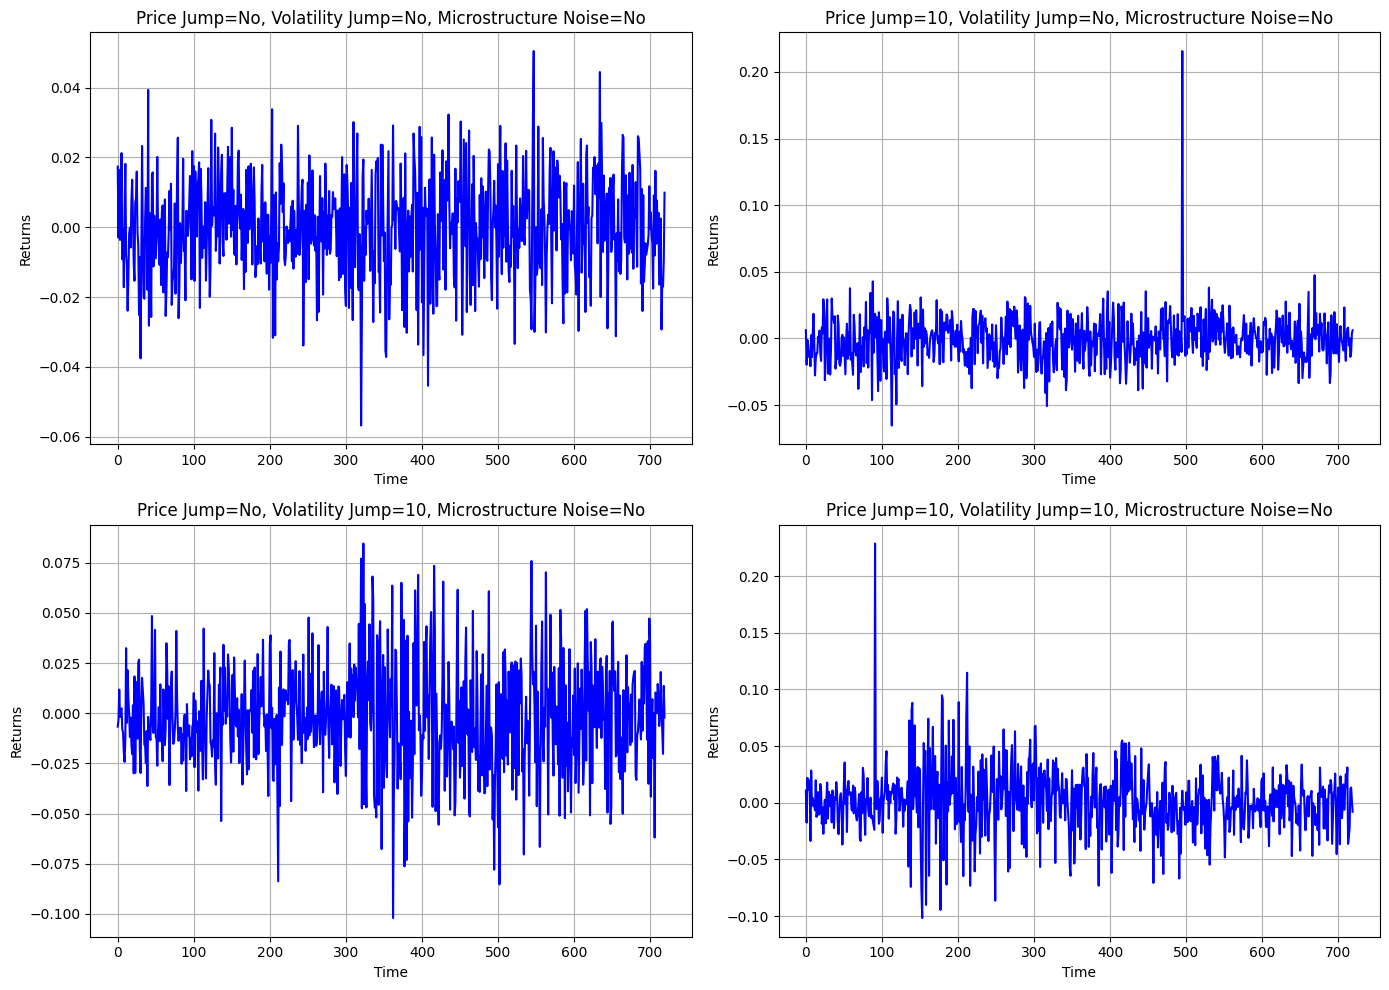

In [2]:
np.random.seed(10) # Set seed here for reproducibility
class DGP:
    def __init__(self, mu=0, kappa=5, rho=-0.5, theta=0.16, sigma_v=0.5, sec=30, price_jump="No", volatility_jump="No", noise="No"):
        self.mu = mu #drift
        self.kappa = kappa #speed of adjustment to the long run mean
        self.rho = rho #correlation between the Brownian increments
        self.theta = theta #long run mean
        self.sigma_v = sigma_v #volatility of the diffusion part
        self.sec = sec #frequency
        self.price_jump = price_jump #size of price jump
        self.volatility_jump = volatility_jump #size of volatility jump
        self.noise = noise #microstructure noise component
        self.dt = 1 / 21600 #time steps, 6 hours of open trading on stock market

    def generate_data(self):
        ######################### Heston model ############################################
        ## Generate multivariate normal variables with correlation parameter (2 vectors)
        W = np.random.multivariate_normal(mean=[0, 0],
                                          cov=[[self.dt, self.dt * self.rho], [self.dt * self.rho, self.dt]],
                                          size=21600)
        ## Generate the volatility process
        v = np.zeros(21600) #create placeholder for volatility process
        v[0] = self.theta #diffusive variance process is initialized at theta
        
        ## Volatility jump construction
        vj_loc = np.random.randint(0, 21600) #generate a random volatility jump time
        if self.volatility_jump != "No":
            jump_multiplier_v = int(self.volatility_jump)
            if 1 <= jump_multiplier_v <= 10:
                v[vj_loc] += jump_multiplier_v * self.theta

        for i in range(1, 21600):
            if i==vj_loc:
                v[i] = v[i - 1] + self.kappa * (self.theta - v[i - 1]) * self.dt + self.sigma_v * np.sqrt(v[i - 1]) * W[i, 0] + v[vj_loc]
                
            elif i!=vj_loc:
                v[i] = v[i - 1] + self.kappa * (self.theta - v[i - 1]) * self.dt + self.sigma_v * np.sqrt(v[i - 1]) * W[i, 0]
                
        ## Generate the returns
        r = np.zeros(21600) #create placeholder for price process
        for i in range(21600):
            r[i] = self.mu * self.dt + np.sqrt(v[i]) * W[i, 1]
    
        ## Price jump construction
        pj_loc = np.random.randint(0, 21600) #generate a random price jump time
        
        if self.price_jump != "No":
            jump_multiplier_p = int(self.price_jump)
            if 1 <= jump_multiplier_p <= 10:
                r[pj_loc] += jump_multiplier_p * np.sqrt(self.theta / 252)
                
        ########################## Microstrucure Noise #################################
        
        ## Generate noise as in Yacine Aït-Sahalia  Jean Jacodc, Jia Li (2012)
        if self.noise != "No":
            pass
            if self.noise == "Gaussian":
                nt = 2 * np.sqrt(self.dt * v) * np.random.normal(loc = 0.0, scale = 1.0, size = 21600)
                r = r + nt
            elif self.noise == "Student":
                df = 2.5
                nt = (2/np.sqrt(df/(df-2))) * np.sqrt(self.dt * v) * np.random.standard_t(df,21600)
                r = r + nt
        
        ####################### Poisson Jump Process ####################################
        
        ## Time grid
        T = 1
        dt = 1 / 21600
        n_steps = int(T / dt)
        time = np.linspace(0, T, n_steps)
        
        lambda_jump = 1.0 # Jump intensity (average jumps per year)
        mu_jump = 0.05    # Mean jump size
        sigma_jump = 0.1  # Std dev of jump size
        
        ## Poisson process for jumps
        N = np.random.poisson(lambda_jump * dt, n_steps)
        jump_sizes = np.random.normal(mu_jump, sigma_jump, n_steps) * N
        jumps = np.cumsum(jump_sizes)
            
        ######################## Aggregate returns #####################################
        
        ## Aggregate returns
        r = np.add.reduceat(r, np.arange(0, len(r), self.sec))
        return r
    
#See some examples
simulator_params = [
    {"price_jump": "No", "volatility_jump": "No", "noise": "No"},
    {"price_jump": 10, "volatility_jump": "No", "noise": "No"},
    {"price_jump": "No", "volatility_jump": 10, "noise": "No"},
    {"price_jump": 10, "volatility_jump": 10, "noise": "No"}
]

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
for i, params in enumerate(simulator_params):
    simulator = DGP(mu=0, kappa=5, rho=-0.5, theta=0.16, sigma_v=0.5, sec=30, **params)
    returns = simulator.generate_data()
    axs[i // 2, i % 2].plot(returns, color='blue')
    axs[i // 2, i % 2].set(title=f'Price Jump={params["price_jump"]}, Volatility Jump={params["volatility_jump"]}, Microstructure Noise={params["noise"]}', xlabel='Time', ylabel='Returns')
    axs[i // 2, i % 2].grid(True)
plt.tight_layout()
plt.show()


# Realized Variance and Bipower Variation

Realized Variance: $RV_{t} = \sum_{i=1}^{M} r_{t_{i}}^{2},$
> where $r_{t_{i}} = p_{t_{i}} - p_{t_{i-1}}$ and $p_{t_{i}}$ is the logarithmic price process

Bipower Variation: $BV_{t} = \frac{\pi}{2} \left( \frac{M}{M-1} \right) \sum_{i=2}^{M} \lvert r_{t_{i}} \lvert \lvert r_{t_{i-1}} \lvert,$ 
> M equally-spaced returns observed

In [3]:
def realized_var(rt: np.array):
    RV = np.sum(np.power(rt, 2))
    return RV

def bipower_var(rt: np.array):
    M = len(rt)
    BV = (np.pi/2) * (M/(M-1)) * np.sum(np.abs(rt[1:]) * np.abs(rt[:-1]))
    return BV

## Tests based on Squared Variation

#### Barndorff-Nielsen and Shephard (2006) Test (BNS)

$T_{BNS,t} = \frac{1-\frac{BV_{t}}{RV_{t}}}{\sqrt{\left( (\frac{\pi}{2})^{2} + \pi - 5 \right) M^{-1} \max(1, \frac{TP_{t}}{BV_{t}^{2}})}} \xrightarrow[]{L} N(0,1) $

> $TP_{t} = \mu_{4/3}^{-3} \left( \frac{M^{2}}{M-2} \right)  \sum_{i=3}^{M} \lvert r_{t_{i-2}} \lvert^{4/3} \lvert r_{t_{i-1}} \lvert^{4/3} \lvert r_{t_{i}} \lvert^{4/3}$

> $\mu_{4/3} = 2^{2/3} \Gamma(7/6) \Gamma(1/2)^{-1}$


#### Corsi, Pirino, and Reno (2010) Test (CPR)

$T_{CPR,t} = \frac{1-\frac{CTBV_{t}}{RV_{t}}}{\sqrt{\left( (\frac{\pi}{2})^{2} + \pi - 5 \right) M^{-1} max(1, \frac{CTriPV_{t}}{CTBV_{t}^{2}})}} \xrightarrow[]{L} N(0,1)$

>$CTBV_{t} = \frac{\pi}{2} \left( \frac{M}{M-1} \right) \sum_{i=2}^{M} \tau_{1,t_{i}}  \tau_{1,t_{i-1}}$

>$CTriPV_{t} = \mu_{4/3}^{-3} \left( \frac{M^{2}}{M-2} \right)  \sum_{i=3}^{M} \tau_{4/3 t_{i-2}}  \tau_{4/3 t_{i-1}}  \tau_{4/3 t_{i}}$

>$\tau_{1,t_{i}} = 
\begin{cases} 
\left| r_{t_i} \right| & \text{for } r_{t_i}^{2} < \upsilon_{t_i} \\
1.094 \sqrt{\upsilon_{t_i}} & \text{for } r_{t_i}^{2} > \upsilon_{t_i}
\end{cases}$

>$\tau_{4/3,t_{i}} = 
\begin{cases} 
\left| r_{t_i} \right|^{4/3} & \text{for } r_{t_i}^{2} < \upsilon_{t_i} \\
1.129 \upsilon_{t_i}^{2/3} & \text{for } r_{t_i}^{2} > \upsilon_{t_i}
\end{cases}$


#### Andersen, Dobrev, and Schaumburg (2009) Tests Based on MinRV

$T_{MinRV,t} = \frac{1-\frac{MinRV_{t}}{RV_{t}}}{\sqrt{1.81 M^{-1} max(1, \frac{MinRQ_{t}}{MinRV_{t}^{2}})}} \xrightarrow[]{L} N(0,1)$

> $MinRV_{t} = \frac{\pi}{\pi-2} \left( \frac{M}{M-1} \right) \sum_{i=2}^{M} \min(|r_{t_{i}}|, |r_{t_{i-1}}|)^2$

> $MinRQ_{t} = \frac{\pi}{3\pi-8} \left( \frac{M^{2}}{M-1} \right) \sum_{i=2}^{M} \min(|r_{t_{i}}|, |r_{t_{i-1}}|)^4$


#### Andersen, Dobrev, and Schaumburg (2009) Tests Based on MedRV

$T_{MedRV,t} = \frac{1-\frac{MedRV_{t}}{RV_{t}}}{\sqrt{0.96 M^{-1} max(1, \frac{MedRQ_{t}}{MedRV_{t}^{2}})}} \xrightarrow[]{L} N(0,1)$

> $MedRV_{t} =  \frac{\pi}{\pi+6-4\sqrt{3}} \left( \frac{M}{M-2} \right) \sum_{i=3}^{M} med(|r_{t_{i}}|, |r_{t_{i-1}}|, |r_{t_{i-2}}|)^2$

> $MedRQ_{t} =  \frac{3\pi}{9\pi+72-52\sqrt{3}} \left( \frac{M^{2}}{M-2} \right) \sum_{i=3}^{M} med(|r_{t_{i}}|, |r_{t_{i-1}}|, |r_{t_{i-2}}|)^4$


In [4]:
def BNS(rt: np.array):

    M, RV, BV = len(rt), realized_var(rt), bipower_var(rt)
    constant = ((2**(2/3))*math.gamma(7/6)*(math.gamma(1/2)**(-1)))**(-3)
    temp = np.sum(np.abs(rt[:-2])**(4/3) * np.abs(rt[1:-1])**(4/3) * np.abs(rt[2:])**(4/3))
    TP = constant * (M**2/(M-2)) * temp
    return (1 - BV / RV) / np.sqrt(((np.pi / 2) ** 2 + np.pi - 5) * M ** -1 * max(1, TP / BV ** 2))


def CPR(rt: np.array, K: int, c: int):
    
    M, RV = len(rt), realized_var(rt)
    temp = np.multiply(np.abs(rt[:-1]), np.abs(rt[1:]))
    Vti = np.zeros(M-K-1) #local variance estimator
    
    for i in range(M-K-1):
        Vti[i] = (np.pi/2) * (1/(K-1)) * np.sum(temp[i: i+K+1])
        
    psi = (c ** 2) * Vti #threshold nu
    r = rt[K+1:]
    
    tau1 = np.where(r <= np.sqrt(psi), np.abs(r), 1.094 * np.sqrt(psi))
    tau43 = np.where(r <= np.sqrt(psi), np.abs(r)**(4/3), 1.129 * psi**(2/3))
    
    Mn = len(tau1) 
    CTBV = (np.pi/2) * (Mn / (Mn-1)) * np.sum(tau1[:-1] * tau1[1:])
    constant = ((2**(2/3))*math.gamma(7/6)*(math.gamma(1/2)**(-1)))**(-3)
    temp2 = np.sum(tau43[0:-2]*tau43[1:-1]*tau43[2:])
    CTPV = constant * (Mn**2 / (Mn-2)) * temp2
    numerator = 1 - (CTBV/RV)
    denumerator = ((np.pi/2)**2 + np.pi - 5) * (1/Mn) * max(1, CTPV/CTBV**2)
    return numerator / np.sqrt(denumerator)

def TMIN(rt: np.array):
    M, RV = len(rt), realized_var(rt)
    temp = np.minimum(np.abs(rt[:-1]), np.abs(rt[1:]))
    MinRV = (np.pi / (np.pi - 2)) * (M / (M - 1)) * np.sum(temp**2)
    MinRQ = (np.pi / (3 * np.pi - 8)) * (M**2 / (M - 1)) * np.sum(temp**4)
    return (1 - MinRV / RV) / np.sqrt((1.81 / M) * max(1, MinRQ / MinRV**2))


def TMED(rt: np.array):
    M, RV = len(rt), realized_var(rt)
    data_med = np.stack([np.abs(rt[0:M-2]), np.abs(rt[1:M-1]), np.abs(rt[2:])])
    MedRV = (np.pi / (np.pi + 6 - 4 * np.sqrt(3))) * (M / (M - 2)) * np.sum(np.median(data_med, axis=0)**2)
    MedRQ = (3 * np.pi / (9 * np.pi + 72 - 52 * np.sqrt(3))) * (M**2 / (M - 2)) * np.sum(np.median(data_med, axis=0)**4  )
    return (1 - MedRV / RV) / np.sqrt(0.96 / M * max(1, MedRQ / MedRV**2))
    

## Tests based on P-power Variation

#### Podolskij and Ziggel (2010) Test (Two variations)

$\displaystyle T_{PZ,t} = \frac{T(P,\Delta_{M})}{\sqrt{Var(\eta_{i}) M^{\frac{P}{2}-1} \sum_{i=1}^{M} \lvert r_{t_{i}} \lvert^{2P} \mathbf{1}_{ \left\{ \lvert r_{t_{i}} \lvert < \sqrt \upsilon(\Delta_{M})^{\omega} \right\}}}} \xrightarrow{L} N(0,1)$

> $T(P,\Delta_{M}) = M^{\frac{P-1}{2}} \sum_{i=1}^{M} \lvert r_{t_{i}} \lvert^{P} \left( 1-\eta_{t_{i}} \mathbf{1}_{ \left\{ \lvert r_{t_{i}} \lvert < \sqrt \upsilon(\Delta_{M})^{\omega} \right\} } \right)$

> $E[\eta_{i}] = 1$ , $E[|\eta_{i}|^{2}]<\infty$


#### The Ait-Sahalia and Jacod (2008) Test (ASJ)

$T_{ASJ,t} = \frac{\hat{S}(P,k,\Delta M)_{t} - k^{P/2-1}}{\sqrt{\hat{\Sigma}_{M,t}^{c}}} \xrightarrow{L} N(0,1),$

> $\displaystyle \hat{\Sigma}_{M,t}^{c} = \frac{\Delta_{M} M(P,k) \hat{A}(2P,\Delta_{M})_{t}}{\hat{A}(P,\Delta_{M})^{2}_{t}}$

> $\hat{A}(P,\Delta_{M})_{t} = \frac{\Delta_{M}^{1-P/2}}{m_{P}} \sum_{i=1}^{M} \lvert r_{t_{i}} \lvert^{P} \mathbf{1}_{ \left\{ \lvert r_{t_{i}} \lvert < \sqrt \upsilon(\Delta_{M})^{\omega} \right\}}$ for $k \geq 2$ and $P > 2$

> $\hat{S}(P,k,\Delta_{M})_{t} = \frac{\hat{B}(P,k\Delta_{M})_{t}}{\hat{B}(P,\Delta_{M})_{t}} \xrightarrow{\Delta_{M} \rightarrow 0} k^{P/2-1}$


In [5]:
def PZ2(rt: np.array, tau: int):

    M, BV = len(rt), bipower_var(rt)
    trunc = 2.3 * np.sqrt(BV) * ((1/M)**(0.4))
    unif = np.random.uniform(size = M)
    eta = np.where(unif <= 0.5, 1-tau, 1+tau)
    
    Bhat2 = np.sqrt(M) * np.sum(np.abs(rt)**2 * (1 - eta * np.where(np.abs(rt) < trunc, 1, 0)))
    Vbar4 = M * np.sum(np.where(np.abs(rt) < trunc,rt**4,0))
    var2 = np.var(eta, ddof = 1) * Vbar4  #Need to set degrees of freedom to 1
    
    return Bhat2/np.sqrt(var2)


def PZ4(rt: np.array, tau: int):

    M, BV = len(rt), bipower_var(rt)
    trunc = 2.3 * np.sqrt(BV) * ((1/M)**(0.4))
    unif = np.random.uniform(size = M)
    eta = np.where(unif <= 0.5, 1-tau, 1+tau)
    
    Bhat4 = M**(3/2) * np.sum(np.abs(rt)**4 * (1 - eta *np.where(np.abs(rt) < trunc, 1, 0)))
    Vbar8 = M**3 * np.sum(np.where(np.abs(rt) < trunc,rt**8,0))
    var4 = np.var(eta,ddof = 1) * Vbar8
    
    return Bhat4/np.sqrt(var4)


def ASJ(rt: np.array, K: int):  # K is the local volatility window size
    
    M = len(rt)
    temp = np.multiply(np.abs(rt[:-1]), np.abs(rt[1:]))
    Vti = np.zeros(M-K-1)
    
    for i in range(M-K-1):
        Vti[i] = (np.pi/2) *(1/(K-1)) * np.sum(temp[i: i+K+1])
    
    mp, m2p, Mpk = 3, 105, (16 * 2) * (2*4-2-1)/3  # Constants for k=2, p=4
    tempr = rt[M - len(Vti):M]
    rtk = tempr[1::2]
    M = len(tempr)
    rtk = tempr[1::2]
    
    Bhat = np.sum(np.abs(np.power(tempr,4)))
    Bhatk = np.sum(np.abs(np.power(rtk,4)))
    Shat = Bhat / Bhatk
    
    trunc = 3*np.sqrt(Vti*M)*((1/M)**0.48)
    Ahat = (M/mp) * np.sum(np.abs(np.power(tempr,4)) * np.where(np.abs(tempr) < trunc,1,0))
    Ahat2 = ((M**3)/m2p) * np.sum(np.abs(np.power(tempr,8)) * np.where(np.abs(tempr) < trunc,1,0))
    
    Sig = (1/M) * Mpk * Ahat2 / (Ahat**2)
    return (Shat - 2) /np.sqrt(Sig)

## Tests based on Standardized Returns

#### Andersen, Bollerslev, and Dobrev (2007)

$T_{ABD,t_{i}} = \frac{|r_{t_{i}}|}{\sqrt{M^{-1}BV_{t}}} \xrightarrow{L} N(0,1)$

#### Lee and Mykland (2008)

$T_{LM,t} = \frac{(\max(\tilde{T}_{LM,t_{i}})-C_{M})}{S_{M}} \xrightarrow{L} \xi \;\;\;\; \mathbf{P}(\xi) = -e^{-x},$

> $\tilde{T}_{LM,t_{i}}$ = $\frac{|r_{t_{i}}|}{\sqrt{\hat{V_{t_{i}}}}}$

> $C_{M} = \frac{(2 \log M)^{1/2}}{0.8} - \frac{\log \pi + \log(\log M)}{1.6 (2 \log \pi)^{1/2}}$

> $S_{M} = \frac{1}{0.6(2 \log \pi)^{1/2}}$

In [6]:
def ABD(rt: np.array):
# The significance level needs to be adjusted for multiple testing.
    M, BV = len(rt), bipower_var(rt)
    return rt / np.sqrt(BV/M)

def LM(rt: np.array, K: int):

    M = len(rt) 
    temp = np.multiply(np.abs(rt[:-1]), np.abs(rt[1:]))
    Vti = np.zeros(M-K-1) #denotes the local variance estimate
    
    for i in range(M-K-1):
        Vti[i] = (np.pi/2) *(1/(K-1)) * np.sum(temp[i: i+K+1])
    
    tempr = rt[M-len(Vti): M]
    Ttil = np.abs(tempr) / np.sqrt(Vti)
    
    Cm = (np.sqrt(2*np.log(M))/0.8) - ((np.log(np.pi)+np.log(np.log(M)))/(1.6*np.sqrt(2*np.log(np.pi))))
    Sm = 1/(0.6*np.sqrt(2*np.log(np.pi)))
    return (np.max(Ttil)-Cm)/Sm
    

## Tests based on Variance Swap

##### Jiang and Oomen (2008) Test

$T_{JO,t} = \frac{BV_{t}}{M^{-1}\sqrt{\hat{\Omega}_{SwV}}} \left( 1 - \frac{RV_{t}}{SwV_{t}} \right) \xrightarrow{L} N(0,1)$

> $SwV_{t} = 2\sum_{i=1}^{M}(R_{t_{i}} - r_{t_{i}}),$

> $plim_{\Delta M \rightarrow 0} (SwV_{t} - RV_{t}) = 
\begin{cases}
0 & \text{ no jumps in [0,t]} \\
2 \int_{0}^{t} \bar{J_{u}} dq_{u} - \int_{0}^{t} J_{u}^{2} dq_{u} & \text{ no jumps in [0,t]}
\end{cases}$

> $\bar{J_{u}} = exp(J_{u}) - J_{u} - 1 \text{ with } J \text{ the jump process.}$

> $\hat{\Omega}_{SwV} = 3.05 \frac{M^{3}}{M-3} \sum_{i=1}^{M} \prod_{k=0}^{3} \lvert r_{t_{i-k}} \lvert^{3/2} \text{ 
  ,} \,\,\,\,\, \text{          } \begin{cases} 
\left| r_{t_i} \right| & \text{for } r_{t_i}^{2} < \upsilon_{t_i} \\
1.094 \sqrt{\upsilon_{t_i}} & \text{for } r_{t_i}^{2} > \upsilon_{t_i}
\end{cases}$

In [7]:
def JO(log_returns: np.array):

    M = len(log_returns)
    returns = np.exp(log_returns)-1
    
    temp = (np.abs(log_returns[:-3]) * 
            np.abs(log_returns[1:-2]) * 
            np.abs(log_returns[2:-1]) * 
            np.abs(log_returns[3:])) ** (3/2)

    Sigma = 3.05 * ((M**3) / (M-3)) * np.sum(temp)

    SWV = 2* np.sum(returns - log_returns)
    BV = bipower_var(log_returns)
    RV = realized_var(log_returns)

    # Calculate the test statistic
    return (M * BV / np.sqrt(Sigma)) * (1 - (RV / SWV))

# Simulate Test Statistic and p-values

In [259]:
class JumpTestSimulator(DGP):
    def __init__(self, mu=0, kappa=5, rho=-0.5, theta=0.16, sigma_v=0.5, sec=30,
                 price_jump="No", volatility_jump="No", noise="No"):
        super().__init__(mu, kappa, rho, theta, sigma_v, sec, price_jump, volatility_jump, noise)
        
        ## Mapping test names to functions ##
        self.test_functions = {'BNS': BNS,'CPR': lambda r: CPR(r, 10, 3),'TMIN': TMIN,'TMED': TMED,
        'PZ2': lambda r: PZ2(r, 0.05),'PZ4': lambda r: PZ4(r, 0.05),'ASJ': lambda r: ASJ(r, 10),
        }
    
    ## P-value calculation methods ##
    @staticmethod
    def calculate_ccdf_upper(element):
        return 1 - norm.cdf(element)
    
    @staticmethod
    def calculate_ccdf_lower(element):
        return norm.cdf(element)

    @staticmethod
    def calculate_ccdf_twoside(element):
        return 2 * (1 - norm.cdf(np.abs(element)))

    @staticmethod
    def calculate_ccdf_gumbel(element):
        return 1 - gumbel_r.cdf(element, loc=0, scale=1)

    ## Z-Transform data for EBM ##
    @staticmethod
    def transform_data(data_vector):
        s = (data_vector - np.mean(data_vector)) / np.std(data_vector)
        ecdf = ECDF(s)
        return -2 * np.log(np.maximum(1 - ecdf(s), 1e-10))

    ## Calculation of covariance matrix ##
    def calculate_covariances(self, data_matrix):
        if isinstance(data_matrix, pd.DataFrame):
            data_matrix = data_matrix.to_numpy()
        transformed = np.apply_along_axis(self.transform_data, 1, data_matrix)
        return np.cov(transformed, rowvar=True)
    
    ## Polynomial fit on correlation for Kost method ##
    @staticmethod
    def kost_poly_fit(cor):
        a1, a2, a3 = 3.263, .710, .027
        return a1 * cor + a2 * cor**2 + a3 * cor**3

    ## Calculation of covariance based on Kost method ##
    def calculate_kost_covariance(self, data_matrix):
        if isinstance(data_matrix, pd.DataFrame):
            data_matrix = data_matrix.to_numpy()
        cor_matrix = np.corrcoef(data_matrix)
        kost_covar_matrix = self.kost_poly_fit(cor_matrix)  # Apply Kost polynomial fit directly
        return kost_covar_matrix

    ## Combining p-values for Fisher, EBM and Kost ##
    @staticmethod
    def combine_p_values(covar_matrix, p_values, method="Brown"):
        m = covar_matrix.shape[0]
        df_fisher = 2.0 * m
        Expected = 2.0 * m
        cov_sum = np.sum(np.triu(covar_matrix, k=1))
        Var = 4.0 * m + 2 * cov_sum
        c = Var / (2.0 * Expected)
        df_brown = min(2.0 * Expected**2 / Var, df_fisher)
        x = 2.0 * np.sum(-np.log(np.clip(p_values, 1e-16, 1)))

        if method == "Brown":
            return 1 - chi2.cdf(x / c, df_brown), x / c, df_brown
        elif method == "Fisher":
            return 1 - chi2.cdf(x, df_fisher), x, df_fisher
        elif method == "Kost":
            return 1 - chi2.cdf(x / c, df_brown), x / c, df_brown
        else:
            raise ValueError("Invalid method. Choose 'Brown', 'Fisher', or 'Kost'.")

    ## Combining p-values for Cauchy method ##
    @staticmethod
    def combine_p_values_cauchy(p_values):
        m = len(p_values)
        if m == 0:
            return 1.0
        t_stat = np.sum(np.tan((0.5 - np.array(p_values)) * np.pi)) / m
        return 0.5 - np.arctan(t_stat) / np.pi, t_stat

    ## Combining p-values for Harmonic method ##
    @staticmethod
    def combine_p_values_harmonic(p_values):
        p_values = np.array(p_values)
        d = len(p_values)
        if d == 0:
            return 1.0
        harmonic_mean_p = d / np.sum(1 / np.clip(p_values, 1e-16, 1))
        return harmonic_mean_p

    def simulate_test_statistics(self, n, frequency, price_jump_category, vol_jump_category, noise_categories):
        # Initialize the attributes that will store results
        self.combined_dataset = defaultdict(lambda: defaultdict(dict))
        self.covariance_matrices = defaultdict(lambda: defaultdict(dict))
        self.p_values = defaultdict(lambda: defaultdict(dict))
        self.additional_results = defaultdict(lambda: defaultdict(dict))
        
        total_iterations = len(price_jump_category) * len(vol_jump_category) * len(noise_categories) * n
        progress_bar = tqdm(total=total_iterations, desc="Simulating Tests", unit="iteration")
        
        for price_jump in price_jump_category:
            for vol_jump in vol_jump_category:
                for noise in noise_categories:
                    test_results = {key: [] for key in self.test_functions.keys()}  
                    for _ in range(n):
                        simulator = DGP(mu=self.mu, kappa=self.kappa, rho=self.rho, theta=self.theta, 
                                         sigma_v=self.sigma_v, sec=frequency,
                                         price_jump=price_jump, volatility_jump=vol_jump, noise=noise)
                        r = simulator.generate_data()

                        for key, func in self.test_functions.items():
                            test_results[key].append(func(r))  # Collect results

                        progress_bar.update(1)

                    # Append the result of each simulation to the list
                    df = pd.DataFrame(test_results)
                    self.combined_dataset[price_jump][vol_jump][noise] = df  
                    cov_matrix = pd.DataFrame(self.calculate_covariances(df.T), index=df.columns, columns=df.columns)
                    self.covariance_matrices[price_jump][vol_jump][noise] = cov_matrix 
                    
                    # Compute correl matrix for Kost
                    cov_matrix_kost = pd.DataFrame(self.calculate_kost_covariance(df.T), index=df.columns, columns=df.columns)
                
                    # Compute transformed p-values
                    df_transformed = df[['BNS', 'CPR', 'TMIN', 'TMED', 'PZ2', 'PZ4']].applymap(self.calculate_ccdf_upper)
                    df_transformed['ASJ'] = df['ASJ'].apply(self.calculate_ccdf_lower)
                    
                    df_additional = pd.DataFrame()

                    # Compute Brown's & Fisher's p-values
                    p_values_brown = [self.combine_p_values(cov_matrix, df_transformed.iloc[i], method='Brown') for i in range(n)]
                    #p_values_fisher = [self.combine_p_values(cov_matrix, df_transformed.iloc[i], method='Fisher') for i in range(n)]
                    p_values_fisher = [self.combine_p_values(cov_matrix.loc[['PZ2', 'PZ4', 'ASJ'], ['PZ2', 'PZ4', 'ASJ']],
                                           df_transformed.loc[i, ['PZ2', 'PZ4', 'ASJ']].values,
                                           method='Fisher') for i in range(n)]
                    p_values_kost = [self.combine_p_values(cov_matrix_kost, df_transformed.iloc[i], method='Kost') for i in range(n)]
                    
                    p_values_cauchy = [self.combine_p_values_cauchy(df_transformed.iloc[i].values) for i in range(n)]
                    p_values_harmonic = [self.combine_p_values_harmonic(df_transformed.iloc[i].values) for i in range(n)]
                
                    # Append p-values to the transformed DataFrame
                    df_transformed['Brown'] = [val[0] for val in p_values_brown]
                    df_additional['Brown_Value'] = [val[1] for val in p_values_brown]
                    df_additional['Brown_DF'] = [val[2] for val in p_values_brown]
                    
                    df_transformed['Fisher'] = [val[0] for val in p_values_fisher]
                    df_additional['Fisher_Value'] = [val[1] for val in p_values_fisher]
                    df_additional['Fisher_DF'] = [val[2] for val in p_values_fisher]
                    
                    df_transformed['Kost'] = [val[0] for val in p_values_kost]
                    df_additional['Kost_Value'] = [val[1] for val in p_values_kost]
                    df_additional['Kost_DF'] = [val[2] for val in p_values_kost] 
                    
                    df_transformed['Cauchy'] =[val[0] for val in p_values_cauchy]
                    df_additional['Cauchy_Value'] = [val[1] for val in p_values_cauchy]
                    
                    df_transformed['Harmonic'] = p_values_harmonic
                    
                    self.p_values[price_jump][vol_jump][noise] = df_transformed 
                    self.additional_results[price_jump][vol_jump][noise] = df_additional 

        progress_bar.close()  # Close progress bar after completion           
        return self.combined_dataset, self.p_values, self.covariance_matrices, self.additional_results


## Generate Test stats, p-values, covar matrix for Size

In [265]:
np.random.seed(10)

simulator = JumpTestSimulator()
combined_dataset, p_values, covariance_matrices, additional_results = simulator.simulate_test_statistics(
    n=10,
    frequency=1,
    price_jump_category=["No"] + [str(i) for i in (1,3,5,7,10)],
    vol_jump_category=["No"] + [str(i) for i in (1,3,5,7,10)],
    noise_categories=["No"]
)
# Convert defaultdicts to regular dictionaries
combined_dataset = dict(combined_dataset)
p_values = dict(p_values)
covariance_matrices = dict(covariance_matrices)
additional_results = dict(additional_results)

# Save data as a pickle file
#with open("output_test_1_1k.pkl", "wb") as file:
    #pickle.dump((combined_dataset, p_values, covariance_matrices), file)












Simulating Tests:   0%|                                                                 | 0/360 [00:00<?, ?iteration/s]









Simulating Tests:   0%|▏                                                        | 1/360 [00:00<01:30,  3.97iteration/s]









Simulating Tests:   1%|▎                                                        | 2/360 [00:00<01:28,  4.06iteration/s]









Simulating Tests:   1%|▍                                                        | 3/360 [00:00<01:30,  3.93iteration/s]









Simulating Tests:   1%|▋                                                        | 4/360 [00:01<01:35,  3.71iteration/s]









Simulating Tests:   1%|▊                                                        | 5/360 [00:01<01:51,  3.18iteration/s]









Simulating Tests:   2%|▉                                                        | 6/360 [00:01<01:43,  3.41iteration/s]









Simulating Tests:   2%|█                                                        | 7/360

Simulating Tests:  14%|███████▉                                                | 51/360 [00:14<01:30,  3.40iteration/s]









Simulating Tests:  14%|████████                                                | 52/360 [00:14<01:28,  3.47iteration/s]









Simulating Tests:  15%|████████▏                                               | 53/360 [00:15<01:27,  3.50iteration/s]









Simulating Tests:  15%|████████▍                                               | 54/360 [00:15<01:29,  3.41iteration/s]









Simulating Tests:  15%|████████▌                                               | 55/360 [00:15<01:28,  3.44iteration/s]









Simulating Tests:  16%|████████▋                                               | 56/360 [00:15<01:26,  3.52iteration/s]









Simulating Tests:  16%|████████▊                                               | 57/360 [00:16<01:27,  3.47iteration/s]









Simulating Tests:  16%|█████████                                               | 58/360 [00:16<01

Simulating Tests:  28%|███████████████▌                                       | 102/360 [00:29<01:19,  3.26iteration/s]









Simulating Tests:  29%|███████████████▋                                       | 103/360 [00:29<01:18,  3.28iteration/s]









Simulating Tests:  29%|███████████████▉                                       | 104/360 [00:29<01:16,  3.33iteration/s]









Simulating Tests:  29%|████████████████                                       | 105/360 [00:29<01:14,  3.40iteration/s]









Simulating Tests:  29%|████████████████▏                                      | 106/360 [00:30<01:13,  3.46iteration/s]









Simulating Tests:  30%|████████████████▎                                      | 107/360 [00:30<01:13,  3.46iteration/s]









Simulating Tests:  30%|████████████████▌                                      | 108/360 [00:30<01:10,  3.55iteration/s]









Simulating Tests:  30%|████████████████▋                                      | 109/360 [00:30<01

Simulating Tests:  42%|███████████████████████▍                               | 153/360 [00:44<00:59,  3.51iteration/s]









Simulating Tests:  43%|███████████████████████▌                               | 154/360 [00:44<00:58,  3.52iteration/s]









Simulating Tests:  43%|███████████████████████▋                               | 155/360 [00:44<00:58,  3.53iteration/s]









Simulating Tests:  43%|███████████████████████▊                               | 156/360 [00:44<00:57,  3.53iteration/s]









Simulating Tests:  44%|███████████████████████▉                               | 157/360 [00:45<00:56,  3.59iteration/s]









Simulating Tests:  44%|████████████████████████▏                              | 158/360 [00:45<00:55,  3.63iteration/s]









Simulating Tests:  44%|████████████████████████▎                              | 159/360 [00:45<00:55,  3.60iteration/s]









Simulating Tests:  44%|████████████████████████▍                              | 160/360 [00:46<00

Simulating Tests:  57%|███████████████████████████████▏                       | 204/360 [00:58<00:47,  3.27iteration/s]









Simulating Tests:  57%|███████████████████████████████▎                       | 205/360 [00:58<00:46,  3.35iteration/s]









Simulating Tests:  57%|███████████████████████████████▍                       | 206/360 [00:59<00:44,  3.46iteration/s]









Simulating Tests:  57%|███████████████████████████████▌                       | 207/360 [00:59<00:43,  3.54iteration/s]









Simulating Tests:  58%|███████████████████████████████▊                       | 208/360 [00:59<00:43,  3.50iteration/s]









Simulating Tests:  58%|███████████████████████████████▉                       | 209/360 [01:00<00:42,  3.57iteration/s]









Simulating Tests:  58%|████████████████████████████████                       | 210/360 [01:00<00:41,  3.63iteration/s]









Simulating Tests:  59%|████████████████████████████████▏                      | 211/360 [01:00<00

Simulating Tests:  71%|██████████████████████████████████████▉                | 255/360 [01:13<00:30,  3.46iteration/s]









Simulating Tests:  71%|███████████████████████████████████████                | 256/360 [01:13<00:30,  3.46iteration/s]









Simulating Tests:  71%|███████████████████████████████████████▎               | 257/360 [01:13<00:29,  3.48iteration/s]









Simulating Tests:  72%|███████████████████████████████████████▍               | 258/360 [01:13<00:28,  3.56iteration/s]









Simulating Tests:  72%|███████████████████████████████████████▌               | 259/360 [01:14<00:27,  3.63iteration/s]









Simulating Tests:  72%|███████████████████████████████████████▋               | 260/360 [01:14<00:27,  3.69iteration/s]









Simulating Tests:  72%|███████████████████████████████████████▉               | 261/360 [01:14<00:28,  3.43iteration/s]









Simulating Tests:  73%|████████████████████████████████████████               | 262/360 [01:15<00

Simulating Tests:  85%|██████████████████████████████████████████████▊        | 306/360 [01:28<00:15,  3.50iteration/s]









Simulating Tests:  85%|██████████████████████████████████████████████▉        | 307/360 [01:28<00:15,  3.50iteration/s]









Simulating Tests:  86%|███████████████████████████████████████████████        | 308/360 [01:29<00:14,  3.54iteration/s]









Simulating Tests:  86%|███████████████████████████████████████████████▏       | 309/360 [01:29<00:14,  3.60iteration/s]









Simulating Tests:  86%|███████████████████████████████████████████████▎       | 310/360 [01:29<00:13,  3.63iteration/s]









Simulating Tests:  86%|███████████████████████████████████████████████▌       | 311/360 [01:29<00:14,  3.48iteration/s]









Simulating Tests:  87%|███████████████████████████████████████████████▋       | 312/360 [01:30<00:13,  3.60iteration/s]









Simulating Tests:  87%|███████████████████████████████████████████████▊       | 313/360 [01:30<00

Simulating Tests:  99%|██████████████████████████████████████████████████████▌| 357/360 [01:42<00:00,  3.70iteration/s]









Simulating Tests:  99%|██████████████████████████████████████████████████████▋| 358/360 [01:43<00:00,  3.64iteration/s]









Simulating Tests: 100%|██████████████████████████████████████████████████████▊| 359/360 [01:43<00:00,  3.62iteration/s]









Simulating Tests: 100%|███████████████████████████████████████████████████████| 360/360 [01:43<00:00,  3.47iteration/s]


In [269]:
#print(additional_results['No']['No']['No'])
additional_results

{'No': defaultdict(dict,
             {'No': {'No':    Brown_Value  Brown_DF  Fisher_Value  Fisher_DF  Kost_Value  Kost_DF  \
               0        0.045     0.111         1.238      6.000       2.460    6.085   
               1        0.029     0.111         2.715      6.000       1.600    6.085   
               2        0.040     0.111         0.563      6.000       2.215    6.085   
               3        0.130     0.111         6.784      6.000       7.106    6.085   
               4        0.050     0.111         4.183      6.000       2.729    6.085   
               5        0.059     0.111         4.019      6.000       3.205    6.085   
               6        0.053     0.111         3.441      6.000       2.874    6.085   
               7        0.056     0.111         4.788      6.000       3.070    6.085   
               8        0.026     0.111         1.600      6.000       1.428    6.085   
               9        0.067     0.111         5.316      6.000       3.

In [248]:
# Show full numbers instead of truncated ones
pd.set_option('display.float_format', '{:.10f}'.format)

# List of target columns
test_names = ['Brown', 'Fisher', 'Kost', 'Cauchy', 'Harmonic']

# Test names and categories
price_jump_category = ["No"] + [str(i) for i in (1, 3, 5, 7, 10)]
vol_jump_category = ["No"] + [str(i) for i in (1, 3, 5, 7, 10)]

results = {vol: {} for vol in vol_jump_category}
# Compute 95th percentile for upper and 5th percentile for lower
for vol in vol_jump_category:
    for col in test_names:
        quantile_value = additional_results['No'][vol]['No'][col].quantile(0.95)
        results[vol][col] = quantile_value



0.027513523419981437

# Load in the simulated data

In [78]:
#with open("output_size_1_10k.pkl", "rb") as file:
with open("output_test_1_1k.pkl", "rb") as file:
    loaded_combined_dataset, loaded_p_values, loaded_covariance_matrices = pickle.load(file)

print("Data loaded successfully!")

Data loaded successfully!


# Calculate the Empirical size of all Tests

In [264]:
pd.set_option('display.float_format', '{:.3f}'.format)

# Extract all test names
test_names = ['BNS', 'CPR', 'TMIN', 'TMED', 'PZ2', 'PZ4', 'ASJ', 'Fisher', 'Brown', 'Kost', 'Cauchy', 'Harmonic']
# Initialize a dictionary to store results
p_results = {}

# Loop through each test and compute the proportion of values < 0.05
for test in test_names:
    values = np.array(p_values['No']['No']['No'][test])  # Convert to NumPy array
    p_results[test] = np.sum(values <= 0.05) / len(values)  # Compute proportion
    
# Convert results to a DataFrame
df_results = pd.DataFrame(list(p_results.items()), columns=['Test', 'Size'])

# Print results
print(df_results)

        Test  Size
0        BNS 0.000
1        CPR 0.000
2       TMIN 0.000
3       TMED 0.000
4        PZ2 0.000
5        PZ4 0.000
6        ASJ 0.000
7     Fisher 0.000
8      Brown 0.000
9       Kost 0.000
10    Cauchy 0.000
11  Harmonic 0.000


# Calculate Empirical Critical Values

In [86]:
import pandas as pd
import numpy as np

# Show full numbers instead of truncated ones
pd.set_option('display.float_format', '{:.10f}'.format)

# List of target columns
upper = ['BNS', 'CPR', 'TMIN', 'TMED', 'PZ2', 'PZ4']
lower = ['ASJ']

# Test names and categories
test_names = upper + lower
price_jump_category = ["No"] + [str(i) for i in (1, 3, 5, 7, 10)]
vol_jump_category = ["No"] + [str(i) for i in (1, 3, 5, 7, 10)]

results = {vol: {} for vol in vol_jump_category}

# Compute 95th percentile for upper and 5th percentile for lower
for vol in vol_jump_category:
    for col in upper:
        quantile_value = loaded_combined_dataset['No'][vol]['No'][col].quantile(0.95)
        results[vol][col] = quantile_value

    for col in lower:
        quantile_value = loaded_combined_dataset['No'][vol]['No'][col].quantile(0.05)
        results[vol][col] = quantile_value

# Convert results to DataFrame
results_df_critical = pd.DataFrame(results).T

# Adjust display precision
pd.set_option('display.float_format', '{:.3f}'.format)

# Initialize list for results
test_results = []

# Loop through each test and compute the proportion of values >= or <= critical value
for test in test_names:
    for price in price_jump_category:
        for vol in vol_jump_category:
            critical_value = results[vol][test]
            values = np.array(loaded_combined_dataset[price][vol]['No'][test])

            # Calculate power
            power = np.sum(values >= critical_value) / max(len(values), 1) if test in upper else \
                np.sum(values <= critical_value) / max(len(values), 1)

            test_results.append({"Test": test, "Price Jump": price, "Vol Jump": vol, "Power": power})

# Convert to DataFrame
results_df_power = pd.DataFrame(test_results)

# Merge critical values with power results
final_results = pd.merge(results_df_power, results_df_critical, left_on="Test", right_index=True)

# Define desired row and column order
desired_column_order = ['No', '1', '3', '5', '7', '10']
desired_row_order = ['BNS', 'CPR', 'TMIN', 'TMED', 'PZ2', 'PZ4', 'ASJ']

# Pivot the table based on different volatility jumps and show results for each vol jump
vol_jump_results = {}
for vol in vol_jump_category:
        filtered_results_vol = results_df_power[results_df_power['Vol Jump'] == vol]
        pivot_table_vol = filtered_results_vol.pivot(index='Test', columns='Price Jump', values='Power')
        pivot_table_vol = pivot_table_vol.reindex(desired_row_order)[desired_column_order]
        vol_jump_results[vol] = pivot_table_vol

# Display results
for vol, pivot_table in vol_jump_results.items():
    print(f"\nPower Results for Volatility Jump: {vol}")
    print(pivot_table)



Power Results for Volatility Jump: No
Price Jump    No     1     3     5     7    10
Test                                          
BNS        0.050 0.136 0.999 1.000 1.000 1.000
CPR        0.050 0.149 0.999 1.000 1.000 1.000
TMIN       0.050 0.091 0.937 1.000 1.000 1.000
TMED       0.050 0.122 0.987 1.000 1.000 1.000
PZ2        0.050 0.992 1.000 1.000 1.000 1.000
PZ4        0.050 0.993 1.000 1.000 1.000 1.000
ASJ        0.050 0.434 0.514 0.532 0.537 0.478

Power Results for Volatility Jump: 1
Price Jump    No     1     3     5     7    10
Test                                          
BNS        0.050 0.128 0.988 1.000 1.000 1.000
CPR        0.050 0.153 0.992 1.000 1.000 1.000
TMIN       0.050 0.096 0.898 1.000 1.000 1.000
TMED       0.050 0.156 0.988 1.000 1.000 1.000
PZ2        0.050 0.964 1.000 1.000 1.000 1.000
PZ4        0.050 0.969 1.000 1.000 1.000 1.000
ASJ        0.050 0.401 0.518 0.505 0.509 0.506

Power Results for Volatility Jump: 3
Price Jump    No     1     3     5     

In [87]:
# Extract test names for combination tests
combination_tests = ['Fisher', 'Brown', 'Kost', 'Cauchy', 'Harmonic']

# List to store results
combination_power_results = []

# Calculate Power for each combination test
for price in price_jump_category:
    for vol in vol_jump_category:
        for test in combination_tests:
            # Extract p-values
            values = np.array(loaded_p_values[price][vol]['No'][test])

            # Calculate Power (proportion of p-values < 0.05)
            power = np.sum(values < 0.05) / max(len(values), 1)

            # Append results
            combination_power_results.append({"Test": test, "Price Jump": price, "Vol Jump": vol, "Power": power})

# Convert to DataFrame
combination_power_df = pd.DataFrame(combination_power_results)

# Append to the existing results DataFrame
final_results_with_combination_power = pd.concat([results_df_power, combination_power_df], ignore_index=True)

# Define desired row and column order
desired_column_order = ['No', '1', '3', '5', '7', '10']
desired_row_order = ['BNS', 'CPR', 'TMIN', 'TMED', 'PZ2', 'PZ4', 'ASJ', 'Fisher', 'Brown', 'Kost', 'Cauchy', 'Harmonic']

# Pivot the table based on different volatility jumps and show results for each vol jump
vol_jump_results = {}
for vol in vol_jump_category:
    filtered_results_vol = final_results_with_combination_power[final_results_with_combination_power['Vol Jump'] == vol]
    pivot_table_vol = filtered_results_vol.pivot(index='Test', columns='Price Jump', values='Power')
    pivot_table_vol = pivot_table_vol.reindex(desired_row_order)[desired_column_order]
    vol_jump_results[vol] = pivot_table_vol

# Display results
for vol, pivot_table in vol_jump_results.items():
    print(f"\nPower Results for Volatility Jump: {vol}")
    print(pivot_table)



Power Results for Volatility Jump: No
Price Jump    No     1     3     5     7    10
Test                                          
BNS        0.050 0.136 0.999 1.000 1.000 1.000
CPR        0.050 0.149 0.999 1.000 1.000 1.000
TMIN       0.050 0.091 0.937 1.000 1.000 1.000
TMED       0.050 0.122 0.987 1.000 1.000 1.000
PZ2        0.050 0.992 1.000 1.000 1.000 1.000
PZ4        0.050 0.993 1.000 1.000 1.000 1.000
ASJ        0.050 0.434 0.514 0.532 0.537 0.478
Fisher     0.140 0.994 1.000 1.000 1.000 1.000
Brown      0.056 0.993 1.000 1.000 1.000 1.000
Kost       0.062 0.993 1.000 1.000 1.000 1.000
Cauchy     0.057 0.993 1.000 1.000 1.000 1.000
Harmonic   0.067 0.994 1.000 1.000 1.000 1.000

Power Results for Volatility Jump: 1
Price Jump    No     1     3     5     7    10
Test                                          
BNS        0.050 0.128 0.988 1.000 1.000 1.000
CPR        0.050 0.153 0.992 1.000 1.000 1.000
TMIN       0.050 0.096 0.898 1.000 1.000 1.000
TMED       0.050 0.156 0.988 1

# Check for outliers

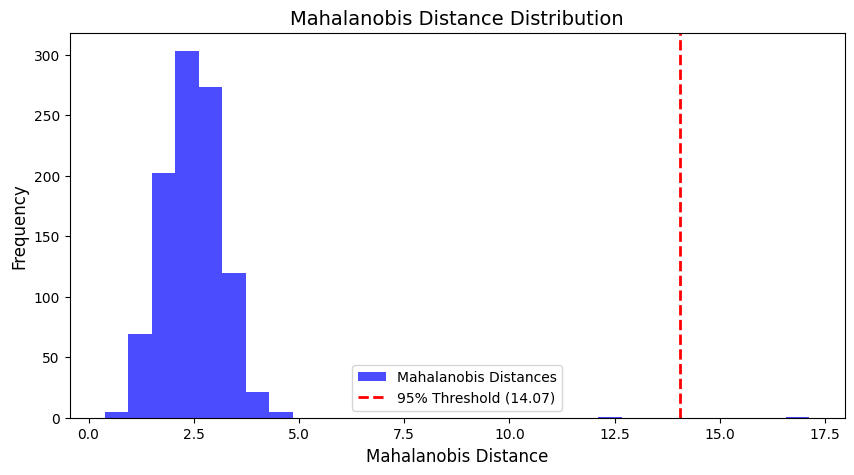

Potential Outliers based on Mahalanobis Distance:
       CPR   BNS  TMIN  TMED   PZ2    PZ4    ASJ
977 0.715 0.460 0.076 0.723 4.017 22.505 -0.112


In [13]:
# Select multiple variables from the dataset
selected_vars = ['CPR', 'BNS', 'TMIN', 'TMED', 'PZ2', 'PZ4', 'ASJ']
data = loaded_combined_dataset['No']['No']['No'][selected_vars]

# Drop any NaN values to avoid issues
data = data.dropna()

# Convert to NumPy array for calculations
data_array = data.to_numpy()

# Compute the mean vector and covariance matrix
mean_vec = np.mean(data_array, axis=0)  # Mean of each column
cov_matrix = np.cov(data_array, rowvar=False)  # Covariance matrix

# Compute the inverse covariance matrix
inv_cov_matrix = np.linalg.inv(cov_matrix)  

# Compute Mahalanobis distance for each observation
diff = data_array - mean_vec  # Difference from mean
mahalanobis_distances = np.sqrt(np.sum(diff @ inv_cov_matrix * diff, axis=1))

# Compute the chi-squared critical value (95% confidence level)
df = len(selected_vars)  # Degrees of freedom = number of variables
chi_squared_threshold = stats.chi2.ppf(0.95, df)

# Plot the Mahalanobis distances
plt.figure(figsize=(10, 5))
plt.hist(mahalanobis_distances, bins=30, alpha=0.7, color='blue', label='Mahalanobis Distances')
plt.axvline(x=chi_squared_threshold, color='red', linestyle='dashed', linewidth=2, label=f'95% Threshold ({chi_squared_threshold:.2f})')

# Labels and title
plt.xlabel('Mahalanobis Distance', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Mahalanobis Distance Distribution', fontsize=14)
plt.legend()
plt.show()

# Identify potential outliers
outliers = data[mahalanobis_distances > chi_squared_threshold]
print("Potential Outliers based on Mahalanobis Distance:\n", outliers)


# Scatterplot showing dependence between Tests

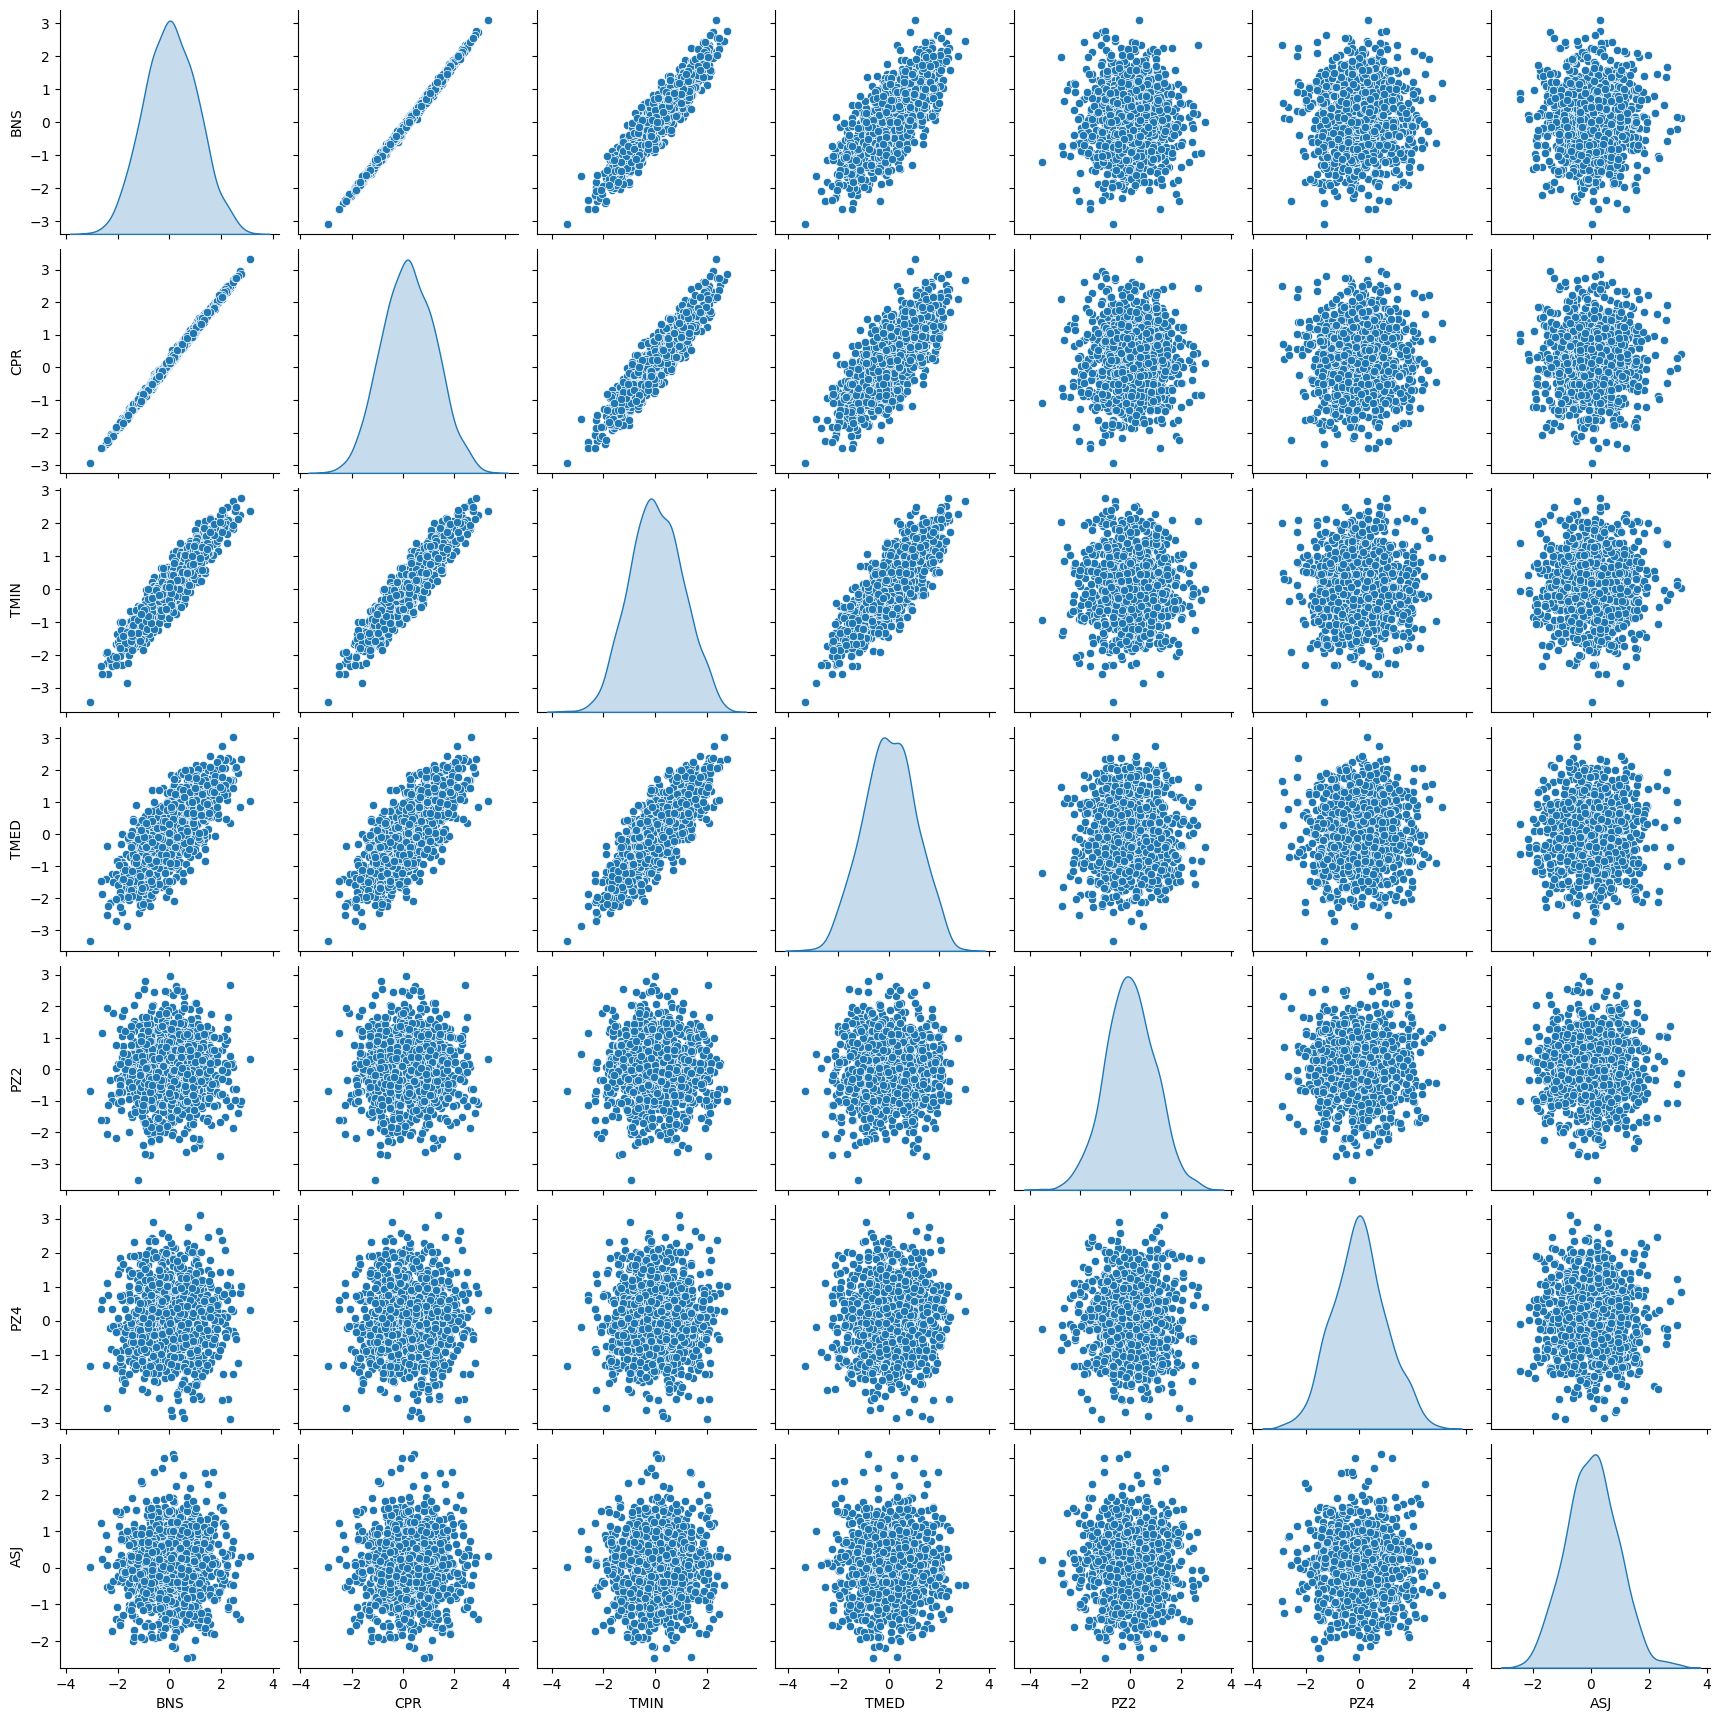

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define selected variables (excluding 'PZ4' since it's not normally distributed)
selected_vars = ['BNS', 'CPR', 'TMIN', 'TMED', 'PZ2', 'PZ4', 'ASJ']  # 'PZ4' is excluded for this analysis

# Extract the relevant data
data = loaded_combined_dataset['No']['No']['No'][selected_vars]

# For 'PZ4', remove the outliers
if 'PZ4' in selected_vars:
    # Identify the two largest values (outliers)
    two_largest_values = np.partition(data['PZ4'], -2)[-2:]
    
    # Remove the two outliers from the dataset
    data = data[~data['PZ4'].isin(two_largest_values)]

# Convert to numeric, handle errors, replace infinities, and drop NaNs in one step
df = data.apply(pd.to_numeric, errors='coerce').replace([np.inf, -np.inf], np.nan).dropna()

# Plot pairplot
sns.pairplot(df, diag_kind="kde")
plt.show()


## Distribution of Tests compared to Normal distribution

In [23]:
from scipy import stats
from scipy.stats import skew, kurtosis
import numpy as np
import pandas as pd

# Ensure proper float formatting
pd.options.display.float_format = '{:.2f}'.format

# Define test names
test_names = ['BNS', 'CPR', 'TMIN', 'TMED', 'PZ2', 'PZ4', 'ASJ']

# Initialize results
normality_results = {}

# Perform normality tests
for name in test_names:
    data = loaded_combined_dataset['No']['No']['No'].get(name, pd.Series(dtype='float64')).dropna()
    if data.empty:
        continue
    # For 'PZ4', remove the outliers
    if name == 'PZ4':
        # Identify the two largest values (outliers)
        two_largest_values = np.partition(data, -2)[-2:]
        
        # Remove the two outliers from the dataset
        data = data[~np.isin(data, two_largest_values)]
        
    mu, std = data.mean(), data.std()
    skewness, kurt = skew(data), kurtosis(data)
    
    # Perform tests
    sw_p_value = stats.shapiro(data)[1] if len(data) <= 5000 else "N/A (Sample > 5000)"
    ad_stat = stats.anderson(data, 'norm')
    ks_p_value = stats.kstest(data, 'norm', args=(mu, std))[1]
    da_p_value = stats.normaltest(data)[1]
    
    # Create an array from 0.01 to 1 with a step size of 0.025
    p_levels = [0.25, 0.1, 0.05, 0.025, 0.01] 

    # Function to estimate p-value based on critical values
    def estimate_ad_p_value(ad_stat, p_levels):
        for s, p in zip(ad_stat.critical_values, p_levels):
            if ad_stat.statistic < s:
                return p
        return 0.005  # Default if statistic exceeds all critical values
    
    # Call the function to estimate Anderson-Darling p-value
    ad_p_value = estimate_ad_p_value(ad_stat, p_levels)
    
    # Store results
    normality_results[name] = {
        "Shapiro-Wilk p-value": sw_p_value,
        "Anderson-Darling p-value": f">{ad_p_value}",
        "Kolmogorov-Smirnov p-value": ks_p_value,
        "D'Agostino-Pearson p-value": da_p_value,
        "Skewness": skewness,
        "Kurtosis": kurt
    }

# Convert to DataFrame and display
normality_results_df = pd.DataFrame(normality_results).T
normality_results_df


Shapiro-Wilk p-value Anderson-Darling p-value Kolmogorov-Smirnov p-value  \
BNS                  0.55                    >0.25                       0.87   
CPR                  0.49                    >0.25                       0.85   
TMIN                 0.06                    >0.25                       0.67   
TMED                 0.06                    >0.25                       0.81   
PZ2                  0.37                    >0.25                       0.92   
PZ4                  0.14                    >0.05                       0.51   
ASJ                  0.11                    >0.25                       0.99   

     D'Agostino-Pearson p-value Skewness Kurtosis  
BNS                        0.14     0.04    -0.27  
CPR                        0.11     0.04    -0.28  
TMIN                       0.06     0.02    -0.32  
TMED                       0.02    -0.05    -0.36  
PZ2                        0.09     0.10     0.30  
PZ4                        0.44     0.09    -0.11  
ASJ                        0.17     0.14     0.03

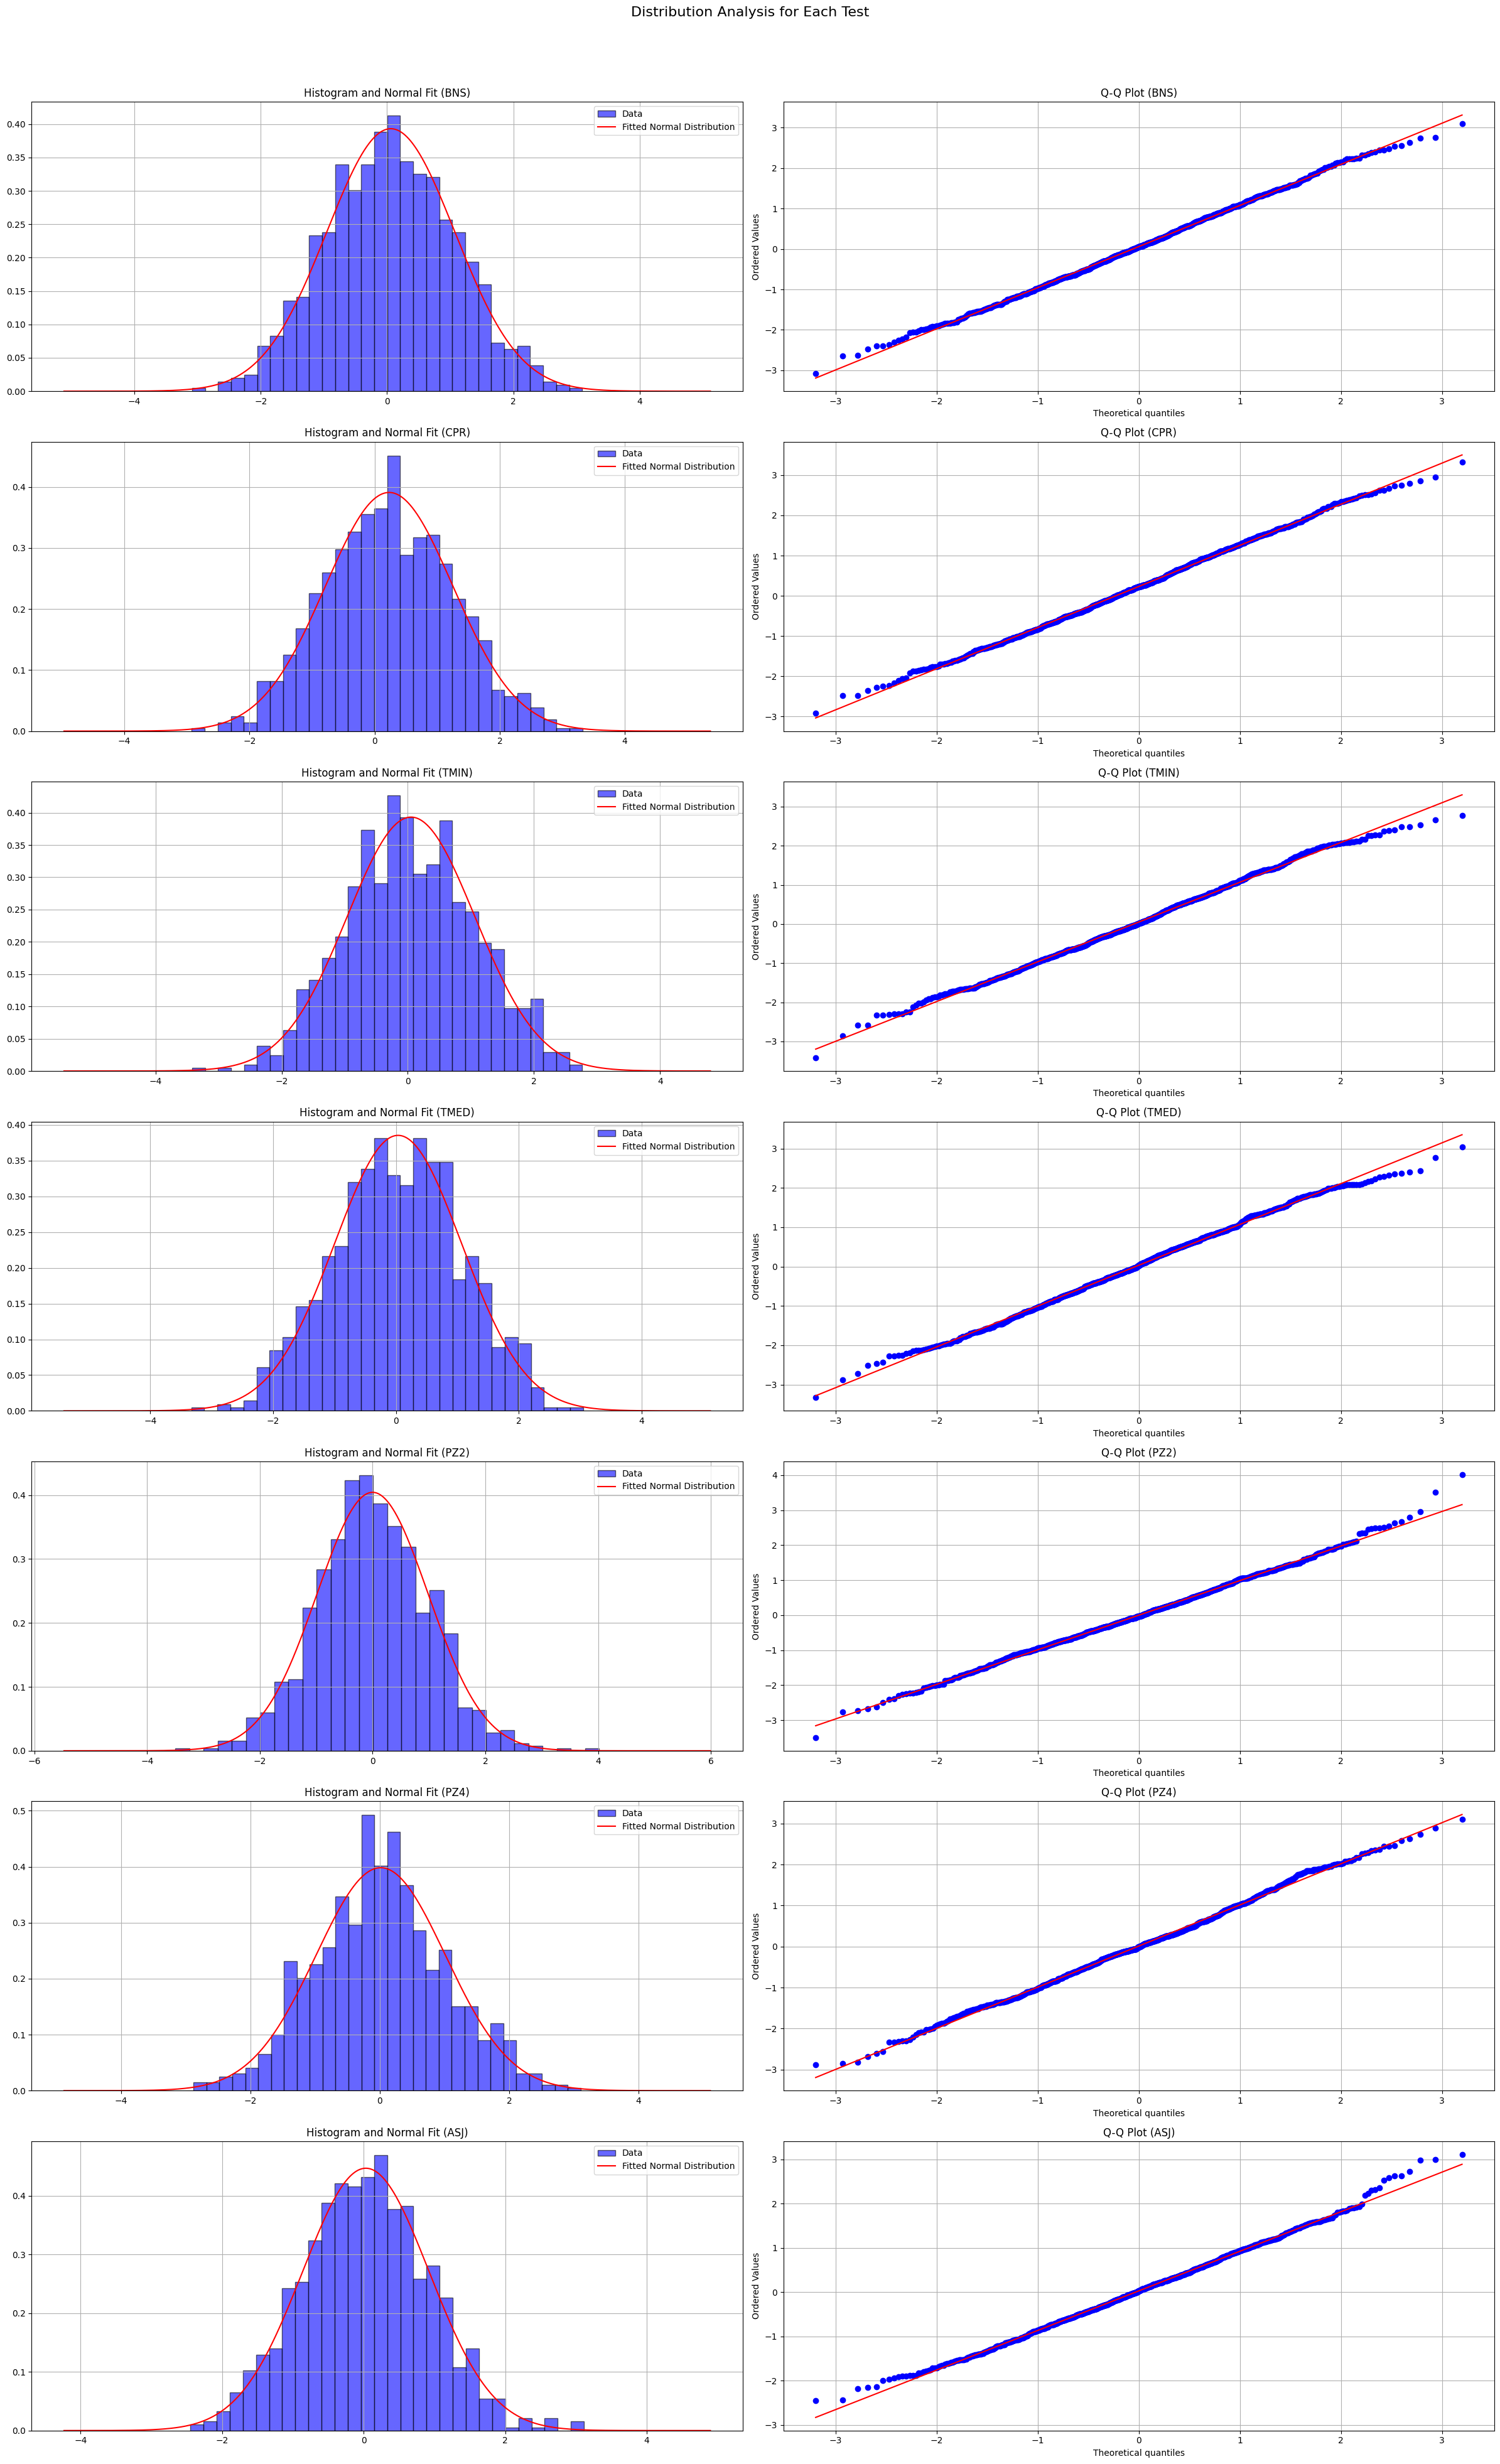

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

# Ensure proper float formatting
pd.options.display.float_format = '{:.3f}'.format

# Define test names
test_names = ['BNS', 'CPR', 'TMIN', 'TMED', 'PZ2', 'PZ4', 'ASJ']

# Create a grid layout with 2 columns: Histogram and Q-Q Plot for each test name
fig, axes = plt.subplots(len(test_names), 2, figsize=(24, 40))
fig.suptitle('Distribution Analysis for Each Test', fontsize=16)

# Loop through each dataset and create the plots
for i, name in enumerate(test_names):
    data = np.array(loaded_combined_dataset['No']['No']['No'][name])  # Ensure NumPy array
    
    # Handle PZ4 by manually removing the outliers (two largest values)
    if name == 'PZ4':
        # Identify the two largest values (outliers)
        two_largest_values = np.partition(data, -2)[-2:]
        
        # Remove the two outliers from the dataset
        data = data[~np.isin(data, two_largest_values)]
    
    # Histogram and Normal Fit (Column 1 for each test row)
    mu, std = np.mean(data), np.std(data)
    x = np.linspace(min(data) - 2*std, max(data) + 2*std, 5000)
    pdf = stats.norm.pdf(x, mu, std)
    axes[i, 0].hist(data, bins=30, density=True, alpha=0.6, color='blue', edgecolor='black', label='Data')
    axes[i, 0].plot(x, pdf, 'r-', label='Fitted Normal Distribution')
    axes[i, 0].legend()
    axes[i, 0].set_title(f'Histogram and Normal Fit ({name})')
    axes[i, 0].grid(True)

    # Q-Q Plot (Column 2 for each test row)
    stats.probplot(data, dist='norm', plot=axes[i, 1])
    axes[i, 1].set_title(f"Q-Q Plot ({name})")
    axes[i, 1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title

# Show the grid of plots
plt.show()


# Check for Multivariate Normality of Joint Tests

Mardia's Test Results:
HZResults(hz=0.8721600491170634, pval=0.45695872213795874, normal=True)


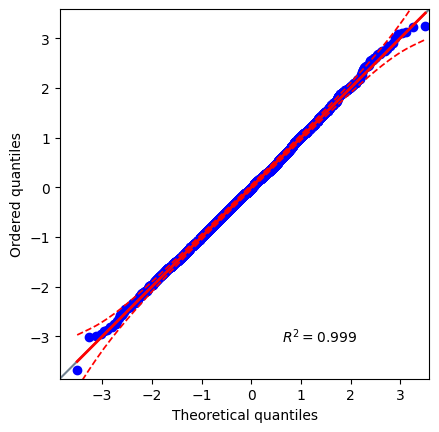

ModuleNotFoundError: No module named 'pyHZ'

In [67]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal, chi2
import pingouin as pg

# Select multiple variables from the dataset
#selected_vars = ['BNS', 'CPR', 'TMIN', 'TMED', 'PZ2', 'PZ4', 'ASJ']
selected_vars = ['PZ2', 'PZ4', 'ASJ']

data = loaded_combined_dataset['No']['No']['No'][selected_vars]

# Handle PZ4 outliers
if 'PZ4' in selected_vars:
    two_largest_values = np.partition(data['PZ4'].dropna(), -2)[-2:]
    data = data[~data['PZ4'].isin(two_largest_values)]

# Drop missing values
data = data.dropna()

# Perform Mardia’s Test using Pingouin
mardia_results = pg.multivariate_normality(data, alpha=0.05)
print("Mardia's Test Results:")
print(mardia_results)

# Plot Q-Q plot
pg.qqplot(data, dist='norm')
plt.show()

from pyHZ import HZTest

# Perform Henze-Zirkler’s test
hz_statistic, p_value = HZTest().test_normality(data.to_numpy())

print(f"Henze-Zirkler Statistic: {hz_statistic}")
print(f"p-Value: {p_value}")

if p_value < 0.05:
    print("Reject the null hypothesis. The data significantly deviates from a multivariate normal distribution.")
else:
    print("Fail to reject the null hypothesis. The data may follow a multivariate normal distribution.")


In [66]:
import numpy as np
import pandas as pd

# Assuming 'loaded_combined_dataset' is already loaded and contains the required data
selected_vars = ['BNS', 'CPR', 'TMIN', 'TMED', 'PZ2', 'PZ4', 'ASJ']
#selected_vars = ['BNS', 'CPR', 'TMIN', 'TMED']
#selected_vars = ['PZ2', 'PZ4', 'ASJ']
data = loaded_combined_dataset['No']['No']['No'][selected_vars]

# Handle 'PZ4' outliers (remove the two largest values)
if 'PZ4' in selected_vars:
    two_largest_values = np.partition(data['PZ4'].dropna(), -2)[-2:]
    data = data[~data['PZ4'].isin(two_largest_values)]

# Drop missing values
data = data.dropna()

# Calculate covariance matrix
cov_matrix = data.cov()

# Display the covariance matrix
print("Covariance Matrix:")
print(cov_matrix)

# Calculate correlation matrix
corr_matrix = data.corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(corr_matrix)

Covariance Matrix:
       BNS   CPR  TMIN  TMED
BNS  1.030 1.035 0.963 0.773
CPR  1.035 1.043 0.967 0.776
TMIN 0.963 0.967 1.030 0.860
TMED 0.773 0.776 0.860 1.074
Correlation Matrix:
       BNS   CPR  TMIN  TMED
BNS  1.000 0.998 0.935 0.735
CPR  0.998 1.000 0.933 0.733
TMIN 0.935 0.933 1.000 0.817
TMED 0.735 0.733 0.817 1.000


In [56]:
from sklearn.cross_decomposition import CCA

# Split variables into two groups for CCA
X = data[['BNS', 'CPR', 'TMIN']]
Y = data[['TMED', 'PZ2', 'PZ4', 'ASJ']]

# Perform Canonical Correlation Analysis
cca = CCA(n_components=2)
cca.fit(X, Y)
X_c, Y_c = cca.transform(X, Y)

print("Canonical Correlation Coefficients:", cca.score(X, Y))


Canonical Correlation Coefficients: 0.1693075786132893


In [59]:
import itertools
from hyppo.independence import Dcorr, MGC

# Prepare data
selected_vars = ['CPR', 'BNS', 'TMIN', 'TMED', 'PZ2', 'PZ4']
data = loaded_combined_dataset['No']['No']['No'][selected_vars]

# Split data into three sets
data_sets = {
    'data1': data[['CPR', 'BNS']].to_numpy(),
    'data2': data[['TMIN', 'TMED']].to_numpy(),
    'data3': data[['PZ2', 'PZ4']].to_numpy()
}

# Perform Dcorr tests
dcorr_test = Dcorr()
for (name1, data1), (name2, data2) in itertools.combinations(data_sets.items(), 2):
    try:
        stat, p_value = dcorr_test.test(data1, data2)
        print(f"Dcorr Test between {name1} and {name2}: stat={stat:.4f}, p-value={p_value:.4f}")
    except Exception as e:
        print(f"Error in Dcorr Test between {name1} and {name2}: {e}")


Dcorr Test between data1 and data2: stat=0.7260, p-value=0.0000
Dcorr Test between data1 and data3: stat=0.0000, p-value=0.3173
Dcorr Test between data2 and data3: stat=0.0001, p-value=0.3018


KeyboardInterrupt: 


===== Analyzing: BNS =====



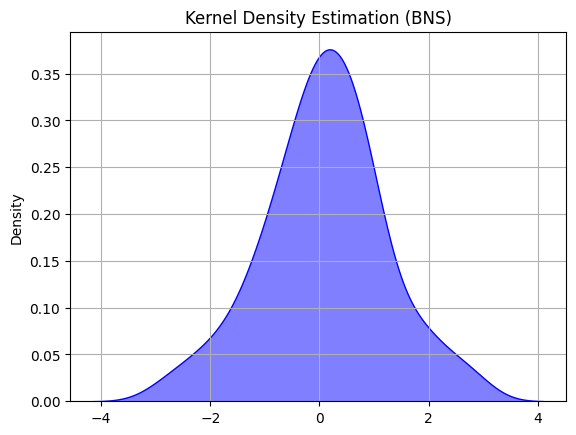

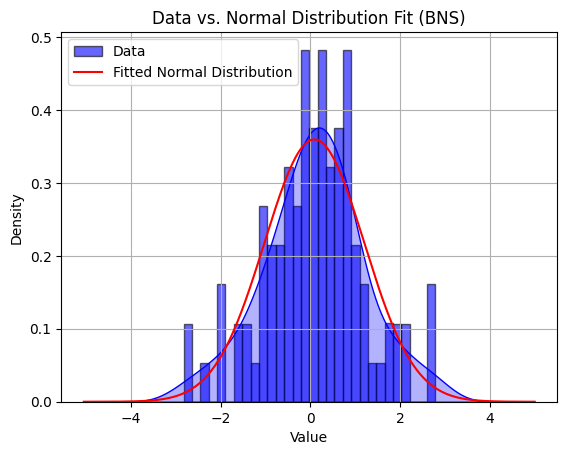

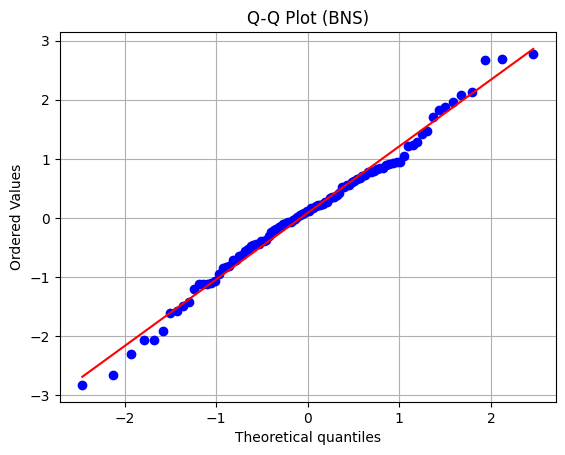

Skewness: -0.081
Kurtosis: 0.274
Shapiro-Wilk test statistic: 0.988, p-value: 0.538
Data is likely normally distributed.
Anderson-Darling Statistic: 0.381
Data is likely normally distributed.
KS test statistic: 0.068, p-value: 0.710
Data is likely normally distributed.
D'Agostino-Pearson test statistic: 0.873, p-value: 0.646
Data is likely normally distributed.

===== Analyzing: CPR =====



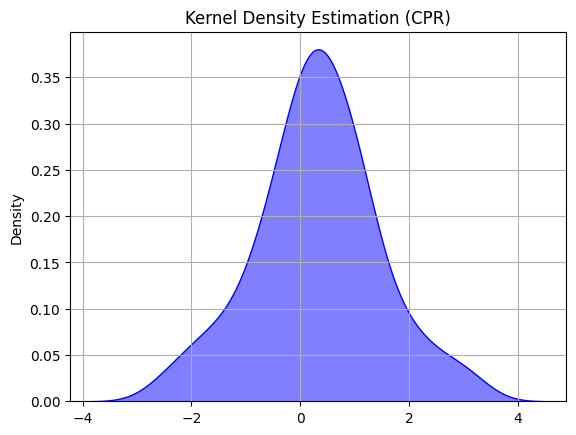

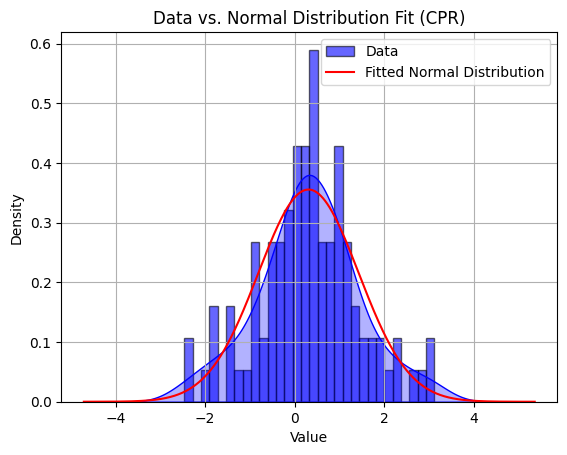

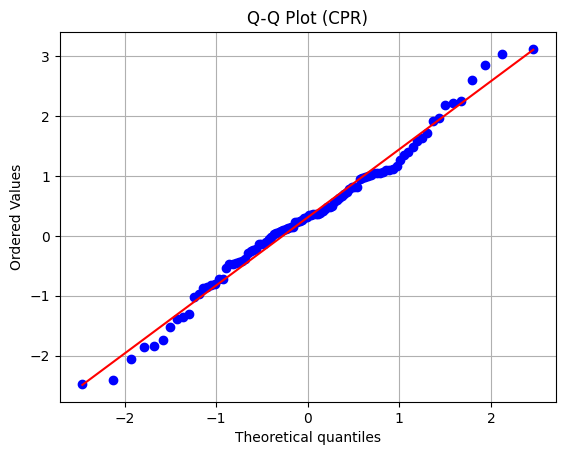

Skewness: -0.008
Kurtosis: 0.288
Shapiro-Wilk test statistic: 0.987, p-value: 0.425
Data is likely normally distributed.
Anderson-Darling Statistic: 0.456
Data is likely normally distributed.
KS test statistic: 0.068, p-value: 0.724
Data is likely normally distributed.
D'Agostino-Pearson test statistic: 0.794, p-value: 0.672
Data is likely normally distributed.

===== Analyzing: TMIN =====



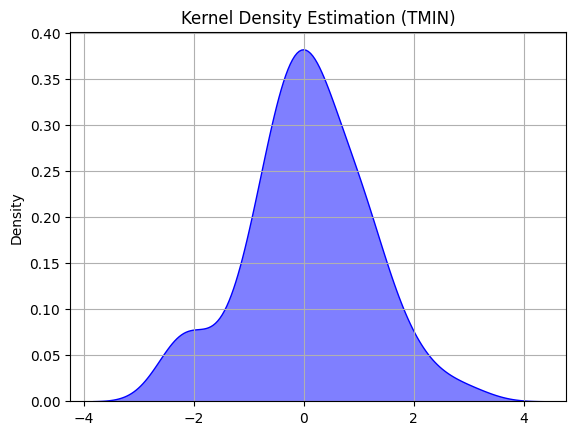

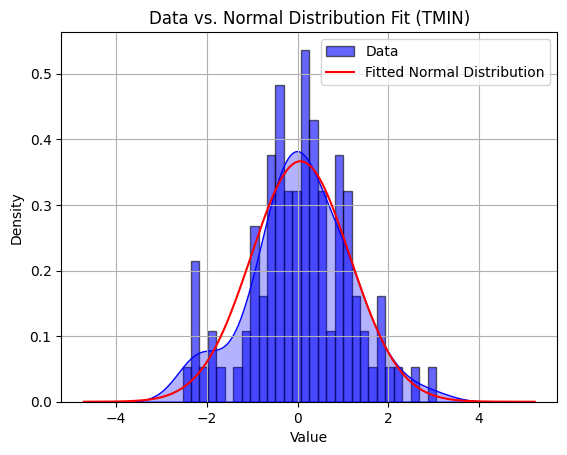

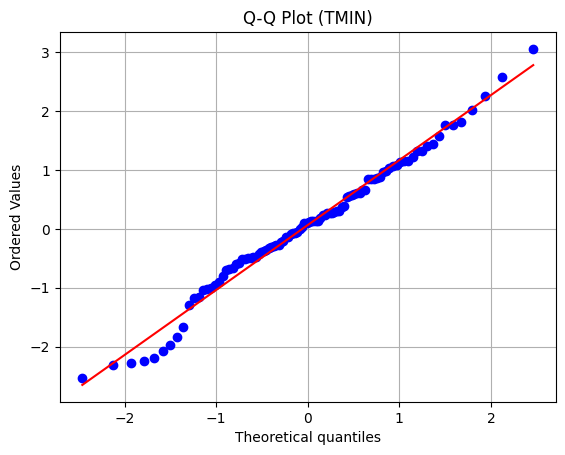

Skewness: -0.094
Kurtosis: 0.231
Shapiro-Wilk test statistic: 0.986, p-value: 0.368
Data is likely normally distributed.
Anderson-Darling Statistic: 0.455
Data is likely normally distributed.
KS test statistic: 0.065, p-value: 0.761
Data is likely normally distributed.
D'Agostino-Pearson test statistic: 0.786, p-value: 0.675
Data is likely normally distributed.

===== Analyzing: TMED =====



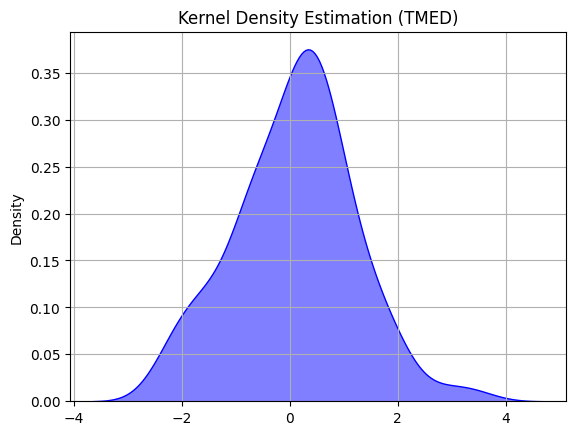

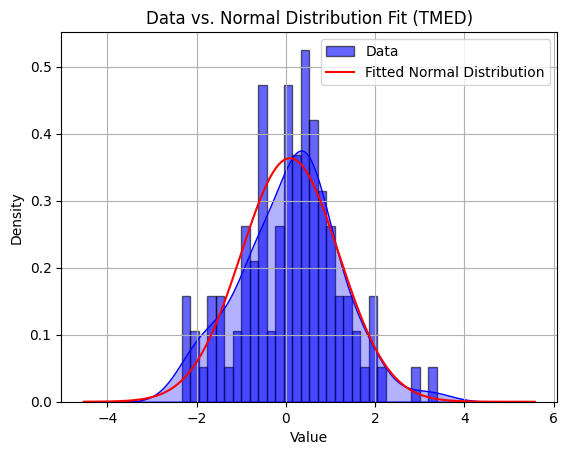

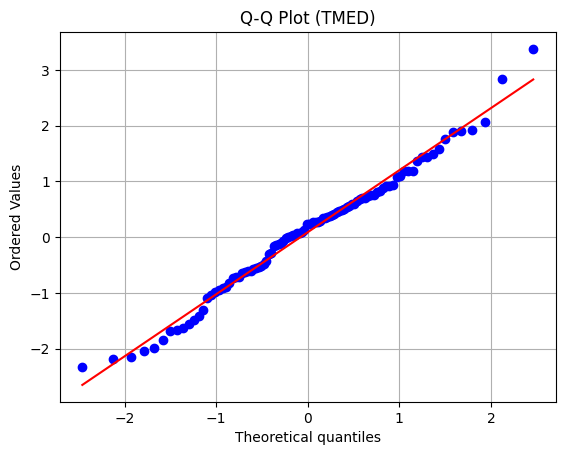

Skewness: 0.039
Kurtosis: 0.168
Shapiro-Wilk test statistic: 0.987, p-value: 0.455
Data is likely normally distributed.
Anderson-Darling Statistic: 0.394
Data is likely normally distributed.
KS test statistic: 0.062, p-value: 0.807
Data is likely normally distributed.
D'Agostino-Pearson test statistic: 0.475, p-value: 0.789
Data is likely normally distributed.

===== Analyzing: PZ2 =====



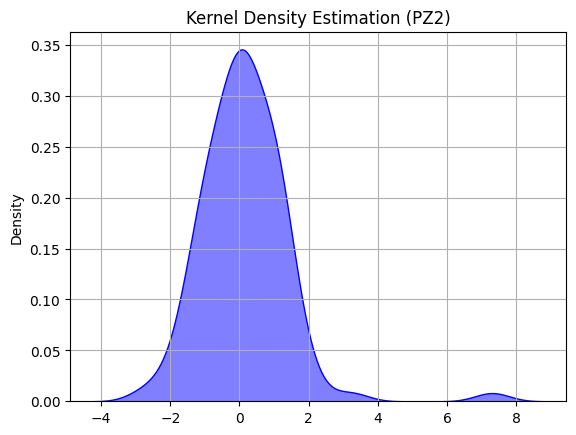

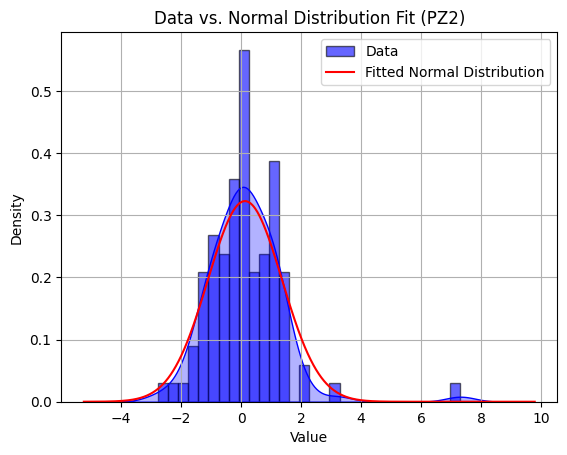

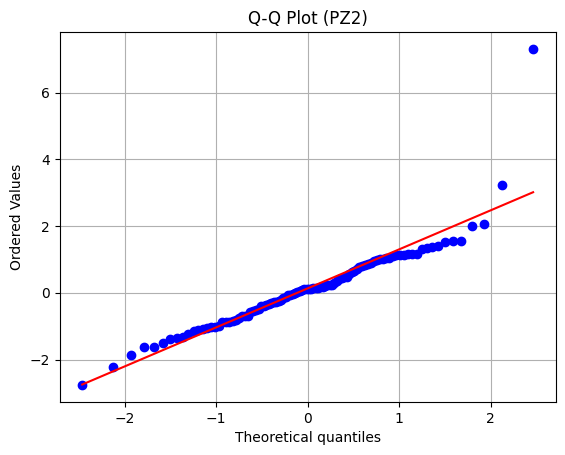

Skewness: 1.839
Kurtosis: 9.776
Shapiro-Wilk test statistic: 0.876, p-value: 0.000
Data is likely not normally distributed.
Anderson-Darling Statistic: 1.264
Data is likely not normally distributed.
KS test statistic: 0.093, p-value: 0.337
Data is likely normally distributed.
D'Agostino-Pearson test statistic: 62.534, p-value: 0.000
Data is likely not normally distributed.

===== Analyzing: PZ4 =====



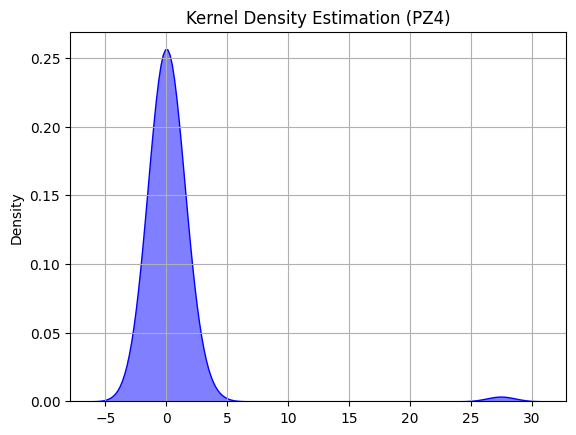

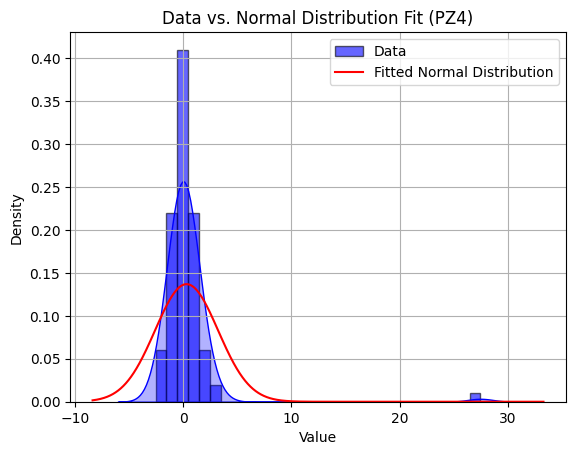

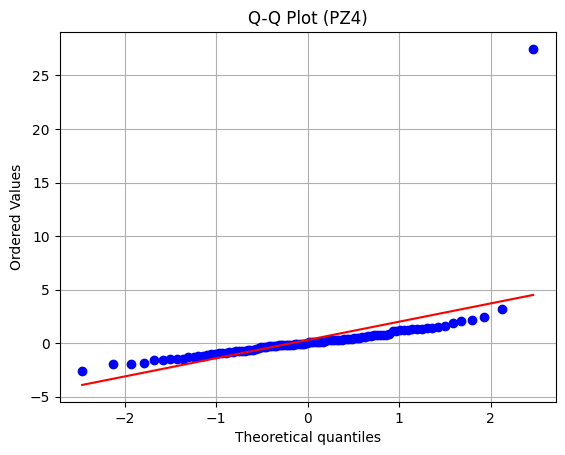

Skewness: 8.062
Kurtosis: 72.407
Shapiro-Wilk test statistic: 0.350, p-value: 0.000
Data is likely not normally distributed.
Anderson-Darling Statistic: 14.712
Data is likely not normally distributed.
KS test statistic: 0.274, p-value: 0.000
Data is likely not normally distributed.
D'Agostino-Pearson test statistic: 193.414, p-value: 0.000
Data is likely not normally distributed.

===== Analyzing: ASJ =====



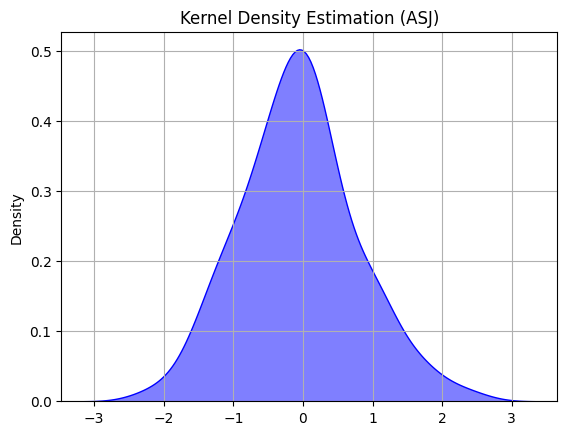

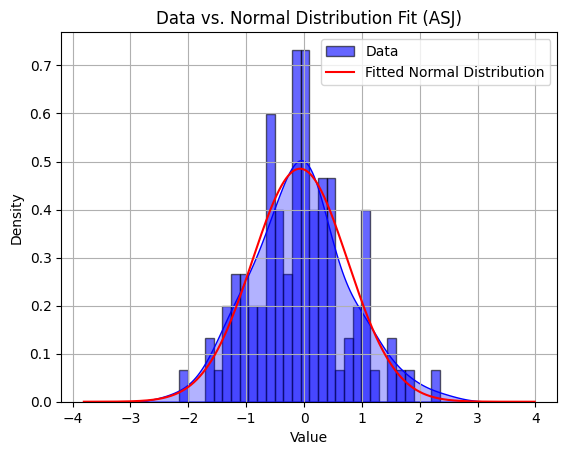

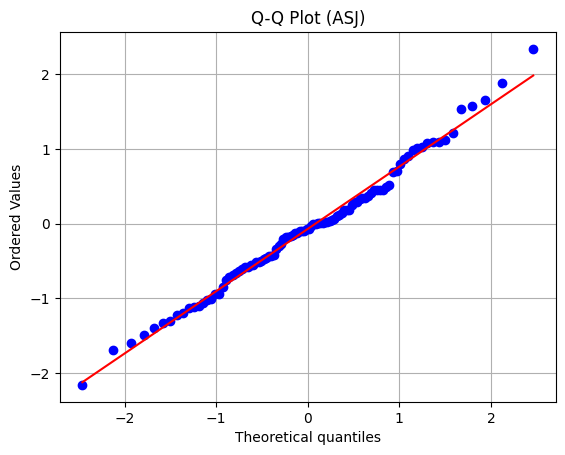

Skewness: 0.236
Kurtosis: 0.190
Shapiro-Wilk test statistic: 0.991, p-value: 0.756
Data is likely normally distributed.
Anderson-Darling Statistic: 0.357
Data is likely normally distributed.
KS test statistic: 0.063, p-value: 0.802
Data is likely normally distributed.
D'Agostino-Pearson test statistic: 1.533, p-value: 0.465
Data is likely normally distributed.


In [109]:
from scipy.stats import skew, kurtosis

# Ensure proper float formatting
pd.options.display.float_format = '{:.3f}'.format

# Define test names
test_names = ['BNS', 'CPR', 'TMIN', 'TMED', 'PZ2', 'PZ4', 'ASJ']

# Loop through each dataset
for name in test_names:
    data = np.array(loaded_combined_dataset['No']['No']['No'][name])  # Ensure NumPy array
    print(f"\n===== Analyzing: {name} =====\n")
    
    # KDE Plot
    sns.kdeplot(data, fill=True, color='blue', alpha=0.5)
    plt.title(f'Kernel Density Estimation ({name})')
    plt.grid(True)
    plt.show()

    # Compute mean and standard deviation
    mu, std = np.mean(data), np.std(data)

    # Define x range for normal distribution plot
    x = np.linspace(min(data) - 2*std, max(data) + 2*std, 5000)

    # Calculate the PDF of the normal distribution
    pdf = stats.norm.pdf(x, mu, std)

    # Plot Histogram and Normal Fit
    plt.hist(data, bins=30, density=True, alpha=0.6, color='blue', edgecolor='black', label='Data')
    sns.kdeplot(data, color='blue', fill=True, alpha=0.3)
    plt.plot(x, pdf, 'r-', label='Fitted Normal Distribution')
    plt.legend()
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title(f'Data vs. Normal Distribution Fit ({name})')
    plt.grid(True)
    plt.show()

    # Q-Q Plot
    stats.probplot(data, dist='norm', plot=plt)
    plt.title(f"Q-Q Plot ({name})")
    plt.grid(True)
    plt.show()

    # Compute Skewness and Kurtosis
    print(f"Skewness: {skew(data):.3f}")
    print(f"Kurtosis: {kurtosis(data):.3f}")

    # Perform Normality Tests

    # Shapiro-Wilk Test
    stat, p_value = stats.shapiro(data)
    print(f"Shapiro-Wilk test statistic: {stat:.3f}, p-value: {p_value:.3f}")
    print("Data is likely normally distributed." if p_value > 0.05 else "Data is likely not normally distributed.")

    # Anderson-Darling Test
    result = stats.anderson(data, dist='norm')
    print(f"Anderson-Darling Statistic: {result.statistic:.3f}")
    if result.statistic < result.critical_values[2]:  # 5% significance level
        print("Data is likely normally distributed.")
    else:
        print("Data is likely not normally distributed.")

    # Kolmogorov-Smirnov Test
    stat, p_value = stats.kstest(data, 'norm', args=(mu, std))
    print(f"KS test statistic: {stat:.3f}, p-value: {p_value:.3f}")
    print("Data is likely normally distributed." if p_value > 0.05 else "Data is likely not normally distributed.")

    # D'Agostino and Pearson's Test
    stat, p_value = stats.normaltest(data)
    print(f"D'Agostino-Pearson test statistic: {stat:.3f}, p-value: {p_value:.3f}")
    print("Data is likely normally distributed." if p_value > 0.05 else "Data is likely not normally distributed.")


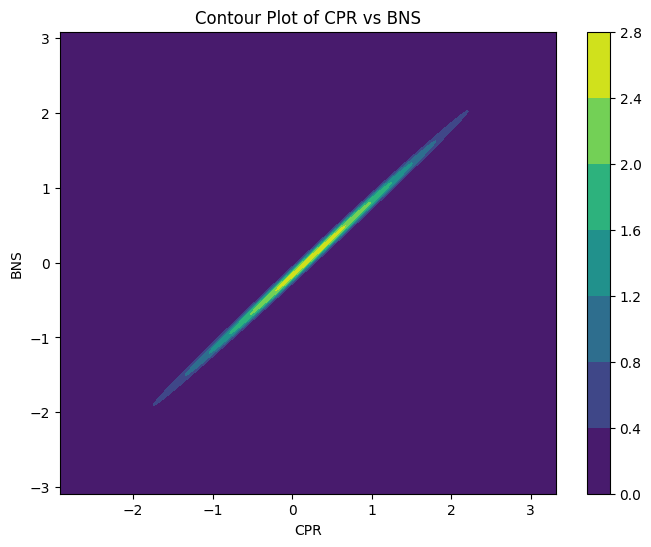

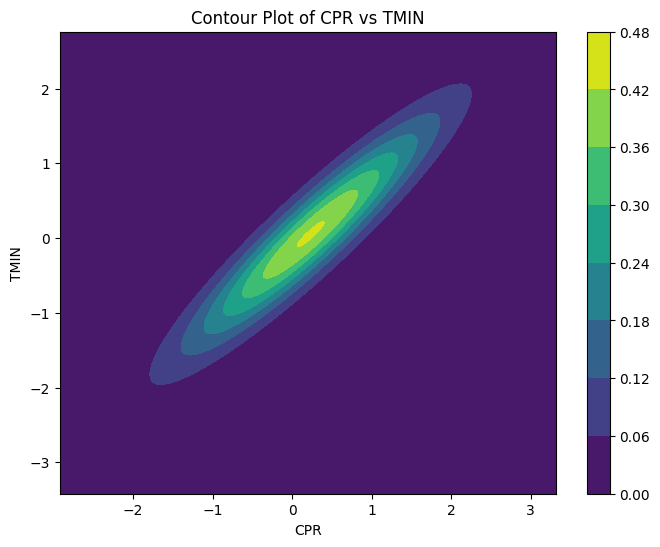

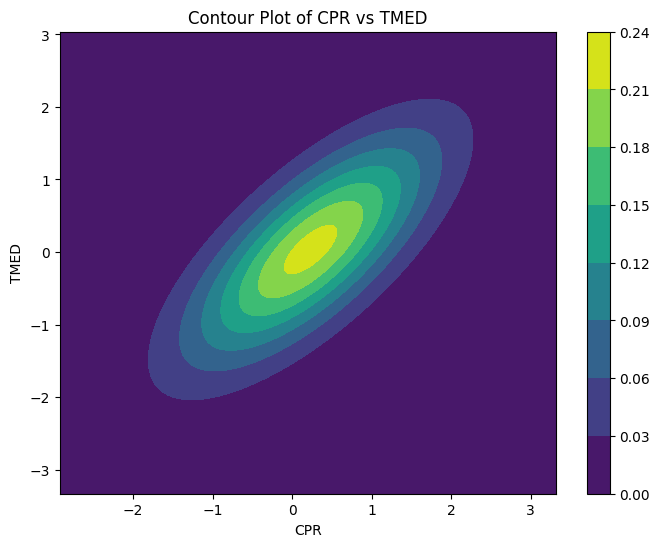

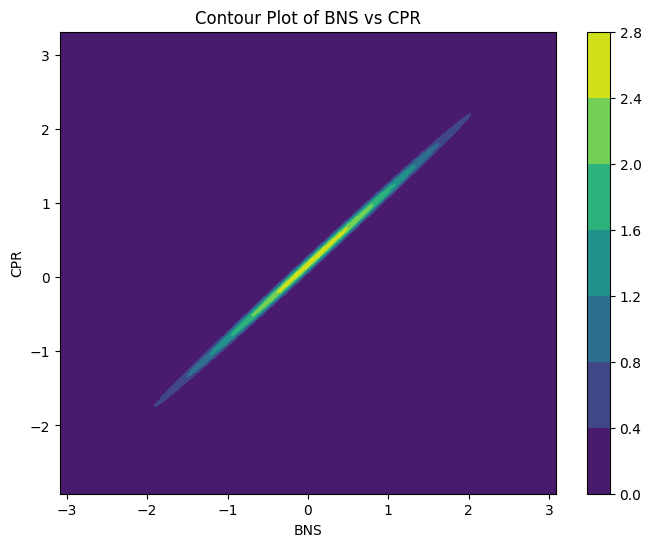

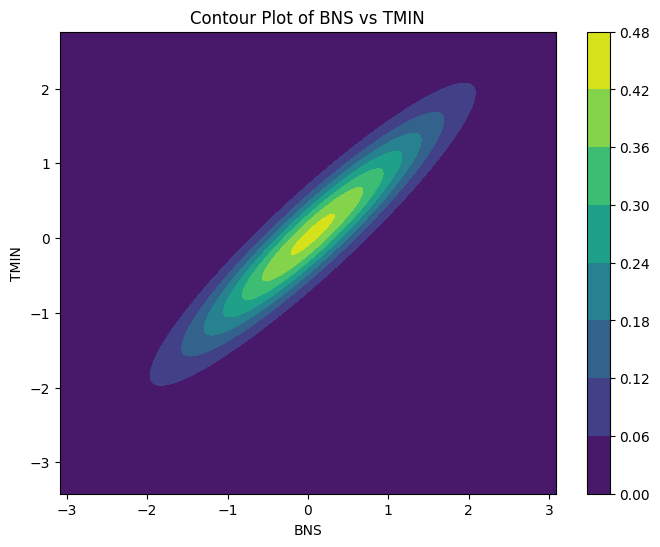

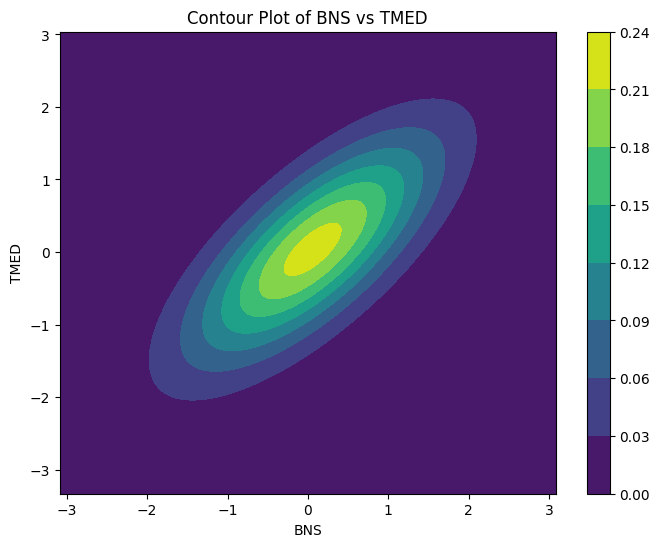

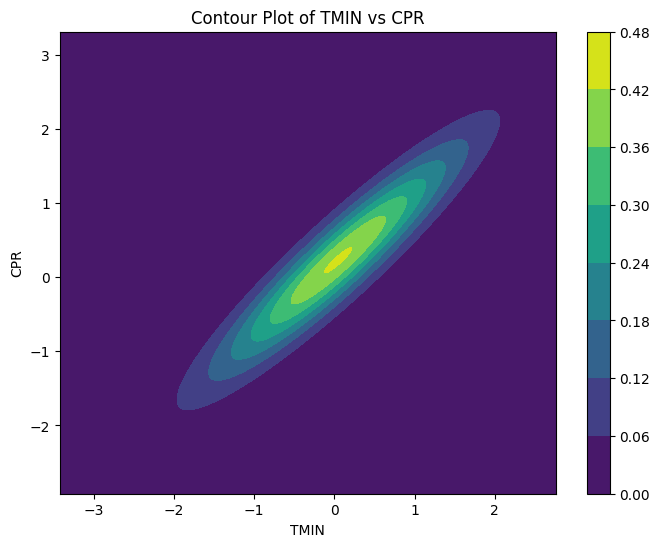

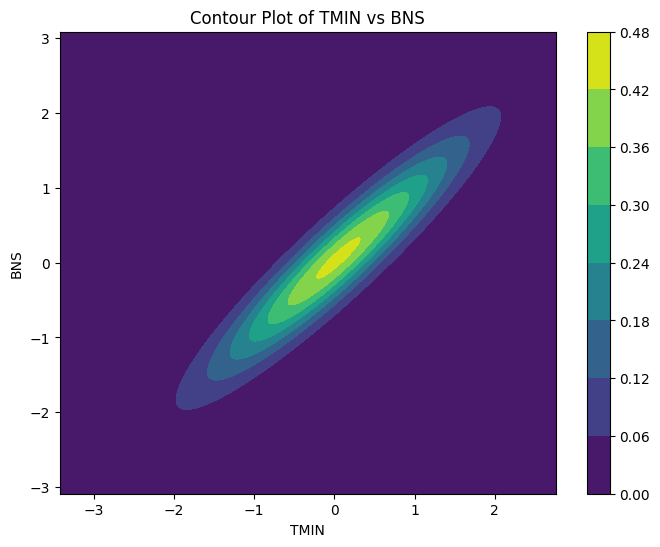

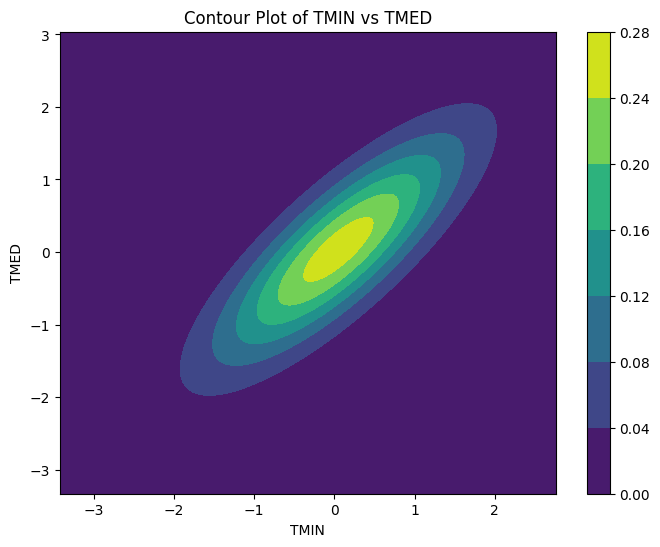

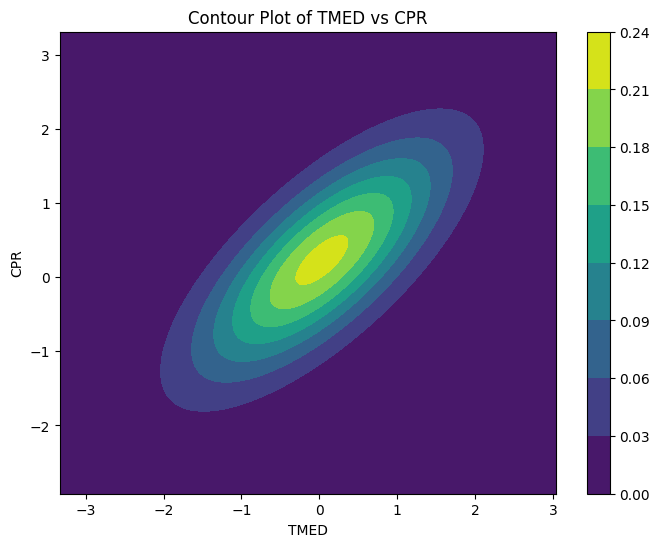

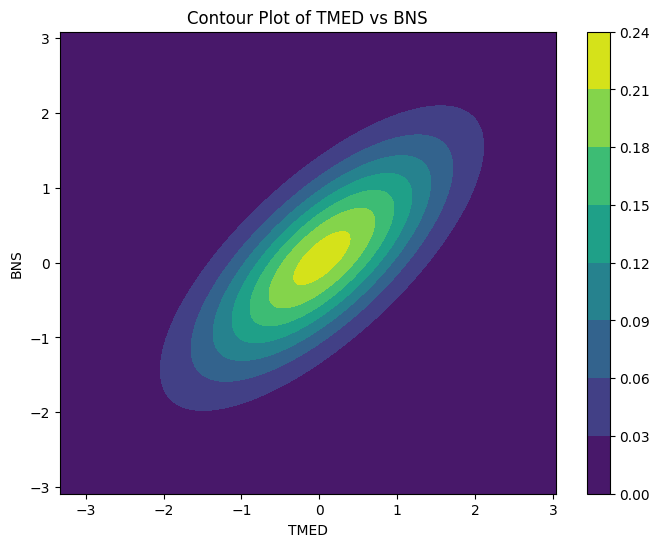

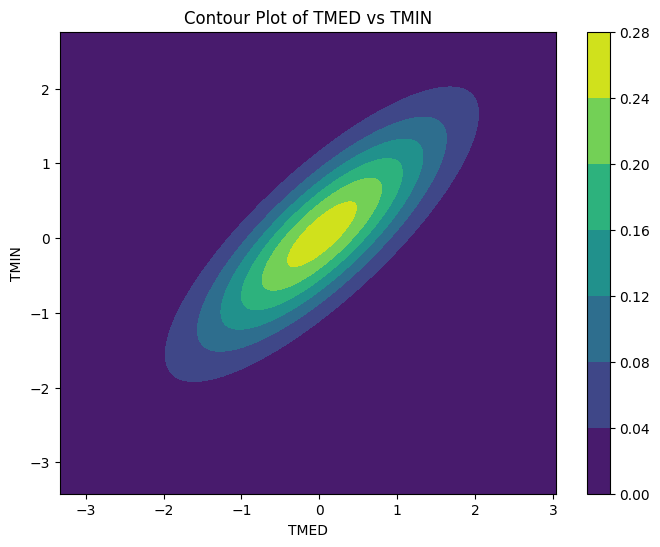

In [129]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Select multiple variables from the dataset
selected_vars = ['CPR', 'BNS', 'TMIN', 'TMED']
data = loaded_combined_dataset['No']['No']['No'][selected_vars]

# Drop missing values (if any)
data = data.dropna()

# Plot the contour plot for each pair of selected variables
for var_x in selected_vars:
    for var_y in selected_vars:
        if var_x != var_y:
            # Define the grid of points for the contour plot
            x, y = np.mgrid[data[var_x].min():data[var_x].max():0.01, 
                            data[var_y].min():data[var_y].max():0.01]
            pos = np.dstack((x, y))

            # Define the mean vector and covariance matrix
            mean = [data[var_x].mean(), data[var_y].mean()]
            cov = np.cov(data[var_x], data[var_y])

            # Create the multivariate normal distribution
            rv = multivariate_normal(mean, cov)

            # Create the figure for plotting
            fig = plt.figure(figsize=(8, 6))
            ax = fig.add_subplot(111)

            # Plot the filled contour plot
            contour = ax.contourf(x, y, rv.pdf(pos), cmap='viridis')

            # Add color bar
            fig.colorbar(contour)

            # Set axis labels and title
            ax.set_xlabel(var_x)
            ax.set_ylabel(var_y)
            ax.set_title(f'Contour Plot of {var_x} vs {var_y}')

            # Show the plot
            plt.show()


In [111]:
pd.options.display.float_format = '{:.3f}'.format
#print(p_values['1']['4']['No'])  # Now displays numbers with 3 decimal places
# Extract p-values for 'LM' test
lm_p_values = p_values['No']['No']['No']['LM']

# Print the p-values
print("P-values for 'LM':", lm_p_values)

# Scatter plot of the p-values
plt.figure(figsize=(8, 6))
plt.scatter(np.arange(len(lm_p_values)), lm_p_values, color='blue', alpha=0.5, s=10)
plt.title("Scatter plot of P-values for 'LM'", fontsize=14)
plt.xlabel("Index")
plt.ylabel("P-value")
plt.grid(True)
plt.show()

KeyError: 'LM'

## P-value scatterplots

In [112]:
import matplotlib.pyplot as plt
import itertools

corr_df = p_values['1']['1']['No'].iloc[:, [0, 1, 2, 3]] 
# Get column names from DataFrame
column_names = corr_df.columns

# Generate all possible pairs of column indices
pairs = list(itertools.combinations(range(len(column_names)), 2))

# Determine the number of rows and columns for subplots
num_pairs = len(pairs)
num_cols = 2  # Number of columns for subplots
num_rows = (num_pairs + num_cols - 1) // num_cols  # Ceiling division

# Create scatterplots for each pair of variables
plt.figure(figsize=(10, 10))
for i, pair in enumerate(pairs):
    plt.subplot(num_rows, num_cols, i + 1)  # Adjust subplot layout based on num_rows and num_cols
    plt.scatter(corr_df.iloc[:, pair[0]], corr_df.iloc[:, pair[1]], alpha=0.5)
    plt.xlabel(column_names[pair[0]])
    plt.ylabel(column_names[pair[1]])
    plt.title(f'Correlation of p-values {column_names[pair[0]]} vs {column_names[pair[1]]}')
    plt.grid(True)

plt.tight_layout()
#plt.savefig('scatter_corr_5min_H0_New_Fisher.pdf')
plt.show()

KeyError: '1'

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Extract p-values for each test
test_names = ['BNS', 'CPR', 'TMIN', 'TMED', 'PZ2', 'PZ4', 'ASJ']
p_values_dict = {name: np.array(loaded_p_values['No']['No']['No'][name]) for name in test_names}

# Create subplot grid
fig, axes = plt.subplots(7, 7, figsize=(20, 20))

for i, test_y in enumerate(test_names):
    for j, test_x in enumerate(test_names):
        ax = axes[i, j]
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_xticks([0, 0.5, 1])
        ax.set_yticks([0, 0.5, 1])

        if i > j:
            ax.scatter(p_values_dict[test_x], p_values_dict[test_y], color='blue', alpha=0.5, s=1)
        elif i == j:
            ax.scatter(p_values_dict[test_x], p_values_dict[test_x], color='black', alpha=0.5, s=1)
        else:
            ax.axis("off")

        if j == 0:
            ax.set_ylabel(test_y, fontsize=20)
        if i == 6:
            ax.set_xlabel(test_x, fontsize=20)

plt.tight_layout()
plt.show()


In [ ]:
# Calculate p-values of one/two-sided tests by substituting Test stats into theoretical asymptotic cdf
def calculate_ccdf_upper(element): return 1 - norm.cdf(element)
def calculate_ccdf_lower(element): return norm.cdf(element)
def calculate_ccdf_twoside(element): return 2 * (1 - norm.cdf(np.abs(element)))
def calculate_ccdf_gumbel(element): return 1 - gumbel_r.cdf(element, loc=0, scale=1)

# Z-Transform of the data and calculate the empirical cumulative distribution function (F)
def TransformData(data_vector):
    s = (data_vector - np.mean(data_vector)) / np.std(data_vector)
    ecdf = ECDF(s)
    return -2 * np.log(np.maximum(1 - ecdf(s), 1e-10))

# For each pair of indices (i; j) calculate the covariance
def CalculateCovariances(data_matrix):
    if isinstance(data_matrix, pd.DataFrame):
        data_matrix = data_matrix.to_numpy()
    transformed = np.apply_along_axis(TransformData, 1, data_matrix)  # Vectorized
    return np.cov(transformed, rowvar=True)

# Use polynomial fits to calculate the covariance introduced by Kost
def KostPolyFit(cor):
    a1, a2, a3 = 3.263, .710, .027 #Kost cubic coeficients
    return a1*cor+a2*cor**2+a3*cor**3

# Calculate covariance based on Kost method
def CalculateKostCovariance(data_matrix):
    if isinstance(data_matrix, pd.DataFrame):
        data_matrix = data_matrix.to_numpy()

    cor_matrix = np.corrcoef(data_matrix)
    kost_covar_matrix = KostPolyFit(cor_matrix)  # Apply Kost polynomial fit directly

    return kost_covar_matrix

def CombinePValues(covar_matrix, p_values, method="Brown"):
    m = covar_matrix.shape[0]
    df_fisher = 2.0 * m
    Expected = 2.0 * m
    cov_sum = np.sum(np.triu(covar_matrix, k=1))
    Var = 4.0 * m + 2 * cov_sum
    c = Var / (2.0 * Expected)
    df_brown = min(2.0 * Expected**2 / Var, df_fisher)

    # Calculate the test statistic using vectorized log and clip
    x = 2.0 * np.sum(-np.log(np.clip(p_values, 1e-16, 1)))

    # Compute p-values using appropriate method
    if method == "Brown":
        return 1 - chi2.cdf(x / c, df_brown)
    elif method == "Fisher":
        return 1 - chi2.cdf(x, df_fisher)
    elif method == "Kost":
        return 1 - chi2.cdf(x / c, df_brown)
    else:
        raise ValueError("Invalid method. Choose 'Brown', 'Fisher', or 'Kost'.")
        
# Combine p-values using the Cauchy method
def CombinePValuesCauchy(p_values):
    m = len(p_values)
    if m == 0:
        return 1.0  # Return max p-value if no values available
    t_stat = np.sum(np.tan((0.5 - np.array(p_values)) * np.pi)) / m
    return 0.5 - np.arctan(t_stat) / np.pi

# Combines a set of p-values using the Harmonic Mean P-Value method.
def CombinePValuesHarmonic(p_values):
    p_values = np.array(p_values)
    d = len(p_values)
    if d == 0:
        return 1.0  # If no p-values, return maximum p-value 
    # Compute harmonic mean of p-values
    harmonic_mean_p = d / np.sum(1 / np.clip(p_values, 1e-16, 1))  # Prevent division by zero
    p_harmonic = harmonic_mean_p
    
    return p_harmonic

def simulate_test_statistics(n, frequency, price_jump_category, vol_jump_category, noise_categories):
    combined_dataset = defaultdict(lambda: defaultdict(dict))
    covariance_matrices = defaultdict(lambda: defaultdict(dict))
    p_values = defaultdict(lambda: defaultdict(dict))
    
    total_iterations = len(price_jump_category) * len(vol_jump_category) * len(noise_categories) * n
    progress_bar = tqdm(total=total_iterations, desc="Simulating Tests", unit="iteration")

    for price_jump in price_jump_category:
        for vol_jump in vol_jump_category:
            for noise in noise_categories:
                test_results = {key: [] for key in ['BNS', 'CPR', 'TMIN', 'TMED', 'PZ2', 'PZ4', 'ASJ']} #,'LM','JO']}
                for _ in range(n):
                    simulator = DGP(mu=0, kappa=5, rho=-0.5, theta=0.16, sigma_v=0.5, sec=frequency,
                                    price_jump=price_jump, volatility_jump=vol_jump, noise=noise)
                    r = simulator.generate_data()
                    test_results['BNS'].append(BNS(r))
                    test_results['CPR'].append(CPR(r, 10, 3))
                    test_results['TMIN'].append(TMIN(r))
                    test_results['TMED'].append(TMED(r))
                    test_results['PZ2'].append(PZ2(r, 0.05))
                    test_results['PZ4'].append(PZ4(r, 0.05))
                    test_results['ASJ'].append(ASJ(r, 10))
                    
                    progress_bar.update(1)  # Update progress bar

                df = pd.DataFrame(test_results)
                combined_dataset[price_jump][vol_jump][noise] = df
                
                # Compute covariance matrix with labeled axes
                test_names = df.columns  # Extract test names
                cov_matrix = pd.DataFrame(CalculateCovariances(df.T), index=test_names, columns=test_names)
                covariance_matrices[price_jump][vol_jump][noise] = cov_matrix
                
                # # Compute correl matrix for Kost
                cov_matrix_kost = pd.DataFrame(CalculateKostCovariance(df.T), index=test_names, columns=test_names)
                
                # Compute transformed p-values
                df_transformed = df.iloc[:, :6].applymap(calculate_ccdf_upper)
                df_transformed['ASJ'] = df['ASJ'].apply(calculate_ccdf_lower)

                # Compute Brown's & Fisher's p-values
                p_values_brown = [CombinePValues(cov_matrix, df_transformed.iloc[i], method = 'Brown') for i in range(n)]
                p_values_fisher = [CombinePValues(cov_matrix, df_transformed.iloc[i], method = 'Fisher') for i in range(n)]
                p_values_kost = [CombinePValues(cov_matrix_kost, df_transformed.iloc[i], method = 'Kost') for i in range(n)]
                p_values_cauchy = [CombinePValuesCauchy(df_transformed.iloc[i].values) for i in range(n)]
                p_values_harmonic = [CombinePValuesHarmonic(df_transformed.iloc[i].values) for i in range(n)]
                
                df_transformed['Brown'] = p_values_brown
                df_transformed['Fisher'] = p_values_fisher
                df_transformed['Kost'] = p_values_kost
                df_transformed['Cauchy'] = p_values_cauchy
                df_transformed['Harmonic'] = p_values_harmonic
                
                p_values[price_jump][vol_jump][noise] = df_transformed

    progress_bar.close()  # Close progress bar after completion           
    return combined_dataset, p_values, covariance_matrices


In [10]:
# Calculate p-values of one/two-sided tests by substituting Test stats into theoretical asymptotic cdf
def calculate_ccdf_upper(element): return 1 - norm.cdf(element)
def calculate_ccdf_lower(element): return norm.cdf(element)
def calculate_ccdf_twoside(element): return 2 * (1 - norm.cdf(np.abs(element)))
def calculate_ccdf_gumbel(element): return 1 - gumbel_r.cdf(element, loc=0, scale=1)

# Z-Transform of the data and calculate the empirical cumulative distribution function (F)
def TransformData(data_vector):
    m, sd = np.mean(data_vector), np.std(data_vector)
    s = (data_vector - m) / sd
    ecdf = ECDF(s)
    return -2 * np.log(np.maximum(1-ecdf(s), 1e-10))

# For each pair of indices (i; j) calculate the covariance
def CalculateCovariances(data_matrix):
    if isinstance(data_matrix, pd.DataFrame):
        data_matrix = data_matrix.to_numpy()
    return np.cov(np.array([TransformData(row) for row in data_matrix]), rowvar=True)

# Use polynomial fits to calculate the covariance introduced by Kost
def KostPolyFit(cor):
    a1, a2, a3 = 3.263, .710, .027 #Kost cubic coeficients
    return a1*cor+a2*cor**2+a3*cor**3

# Calculate covariance based on Kost method
def CalculateKostCovariance(data_matrix):
    if isinstance(data_matrix, pd.DataFrame):
        data_matrix = data_matrix.to_numpy()
        m = data_matrix.shape[0]
        covar_matrix = np.zeros((m, m))
        for i in range(m):
            for j in range(i+1, m):
                cor, p_val = pearsonr(data_matrix[i, :], data_matrix[j, :])
                covar = KostPolyFit(cor)
                covar_matrix[i, j] = covar_matrix[j, i] = covar
    return covar_matrix

#def KostsMethod(data_matrix, p_values, extra_info = False):
    #covar_matrix = CalculateKostCovariance(data_matrix)
    #return CombinePValues(covar_matrix, p_values)

# Combine p-values based on differetn methods
def CombinePValues(covar_matrix, p_values, method="Brown"):
    m = covar_matrix.shape[0]
    df_fisher = 2.0 * m
    Expected = 2.0 * m
    cov_sum = 0
    for i in range(m):
        for j in range(i+1, m):
            cov_sum += covar_matrix.iloc[i, j] 
    Var = 4.0 * m + 2 * cov_sum
    c = (4.0 * m + 2 * cov_sum) / (2.0 * Expected)
    df_brown = min(2.0 * Expected**2 / Var, df_fisher)
    x = 2.0 * np.sum(-np.log(np.clip(p_values, 1e-16, 1)))
    
    # Compute the p-value based on the chosen method
    if method == "Brown":
        return 1 - chi2.cdf(x / c, df_brown)
    elif method == "Fisher":
        return 1 - chi2.cdf(x, df_fisher)
    elif method == "Kost":
        return 1 - chi2.cdf(x / c, df_brown)
    else:
        raise ValueError("Invalid method. Choose 'Brown', 'Fisher', or 'Kost'.")
        
# Combine p-values using the Cauchy method
def CombinePValuesCauchy(p_values):
    m = len(p_values)
    if m == 0:
        return 1.0  # Return max p-value if no values available
    t_stat = np.sum(np.tan((0.5 - np.array(p_values)) * np.pi)) / m
    return 0.5 - np.arctan(t_stat) / np.pi

# Combines a set of p-values using the Harmonic Mean P-Value method.
def CombinePValuesHarmonic(p_values):
    p_values = np.array(p_values)
    d = len(p_values)
    if d == 0:
        return 1.0  # If no p-values, return maximum p-value 
    # Compute harmonic mean of p-values
    harmonic_mean_p = d / np.sum(1 / np.clip(p_values, 1e-16, 1))  # Prevent division by zero
    p_harmonic = harmonic_mean_p
    
    return p_harmonic

def simulate_test_statistics(n, frequency, noise_categories, vol_jump_category, price_jump_category):
    combined_dataset = defaultdict(lambda: defaultdict(dict))
    covariance_matrices = defaultdict(lambda: defaultdict(dict))
    p_values = defaultdict(lambda: defaultdict(dict))
    
    total_iterations = len(vol_jump_category) * len(price_jump_category) * len(noise_categories) * n
    progress_bar = tqdm(total=total_iterations, desc="Simulating Tests", unit="iteration")

    for vol_jump in vol_jump_category:
        for price_jump in price_jump_category:
            for noise in noise_categories:
                test_results = {key: [] for key in ['BNS', 'CPR', 'TMIN', 'TMED', 'PZ2', 'PZ4', 'ASJ','LM']}#,'JO']}
                for _ in range(n):
                    simulator = DGP(mu=0, kappa=5, rho=-0.5, theta=0.16, sigma_v=0.5, sec=frequency,
                                    price_jump=price_jump, volatility_jump=vol_jump, noise=noise)
                    r = simulator.generate_data()
                    test_results['BNS'].append(BNS(r))
                    test_results['CPR'].append(CPR(r, 10, 3))
                    test_results['TMIN'].append(TMIN(r))
                    test_results['TMED'].append(TMED(r))
                    test_results['PZ2'].append(PZ2(r, 0.05))
                    test_results['PZ4'].append(PZ4(r, 0.05))
                    test_results['ASJ'].append(ASJ(r, 10))
                    test_results['LM'].append(LM(r, 10))
                    #test_results['JO'].append(JO(r))
                    
                    progress_bar.update(1)  # Update progress bar

                df = pd.DataFrame(test_results)
                combined_dataset[vol_jump][price_jump][noise] = df
                
                # Compute covariance matrix with labeled axes
                test_names = df.columns  # Extract test names
                cov_matrix = pd.DataFrame(CalculateCovariances(df.T), index=test_names, columns=test_names)
                covariance_matrices[vol_jump][price_jump][noise] = cov_matrix
                
                # # Compute correl matrix for Kost
                cov_matrix_kost = pd.DataFrame(CalculateKostCovariance(df.T), index=test_names, columns=test_names)
                
                # Compute transformed p-values
                df_transformed = df.iloc[:, :6].applymap(calculate_ccdf_upper)
                df_transformed['ASJ'] = df['ASJ'].apply(calculate_ccdf_lower)
                df_transformed['LM'] = df['LM'].apply(calculate_ccdf_gumbel)
                #df_transformed['JO'] = df['JO'].apply(calculate_ccdf_twoside)

                # Compute Brown's & Fisher's p-values
                p_values_brown = [CombinePValues(cov_matrix, df_transformed.iloc[i], method = 'Brown') for i in range(n)]
                p_values_fisher = [CombinePValues(cov_matrix, df_transformed.iloc[i], method = 'Fisher') for i in range(n)]
                p_values_kost = [CombinePValues(cov_matrix_kost, df_transformed.iloc[i], method = 'Kost') for i in range(n)]
                p_values_cauchy = [CombinePValuesCauchy(df_transformed.iloc[i].values) for i in range(n)]
                p_values_harmonic = [CombinePValuesHarmonic(df_transformed.iloc[i].values) for i in range(n)]
                
                df_transformed['Brown'] = p_values_brown
                df_transformed['Fisher'] = p_values_fisher
                df_transformed['Kost'] = p_values_kost
                df_transformed['Cauchy'] = p_values_cauchy
                df_transformed['Harmonic'] = p_values_harmonic
                
                p_values[vol_jump][price_jump][noise] = df_transformed

    progress_bar.close()  # Close progress bar after completion           
    return combined_dataset, p_values, covariance_matrices

In [ ]:
import pandas as pd

# Assuming additional_results['No']['No']['No']['Brown'],
# additional_results['No']['No']['No']['Fisher'],
# and additional_results['No']['No']['No']['Kost'] contain tuples in their first columns

df_brown = pd.DataFrame(additional_results['No']['No']['No']['Brown'])
df_fisher = pd.DataFrame(additional_results['No']['No']['No']['Fisher'])
df_kost = pd.DataFrame(additional_results['No']['No']['No']['Kost'])

# Define a function to split the tuples and add new columns
def split_tuple(df, prefix):
    # Use iloc to access the first column (index 0)
    df[[f'{prefix}_1', f'{prefix}_2']] = pd.DataFrame(df.iloc[:, 0].tolist(), index=df.index)
    return df.drop(columns=[df.columns[0]])  # Drop the original first column

# Apply the function to each DataFrame
df_brown = split_tuple(df_brown, 'Brown')
df_fisher = split_tuple(df_fisher, 'Fisher')
df_kost = split_tuple(df_kost, 'Kost')

# Creating and updating each DataFrame in the additional_results dictionary
additional_brown = pd.DataFrame(additional_results['No']['No']['No']['Brown'])
additional_brown = pd.concat([additional_brown, df_brown[['Brown_1', 'Brown_2']]], axis=1)

additional_fisher = pd.DataFrame(additional_results['No']['No']['No']['Fisher'])
additional_fisher = pd.concat([additional_fisher, df_fisher[['Fisher_1', 'Fisher_2']]], axis=1)

additional_kost = pd.DataFrame(additional_results['No']['No']['No']['Kost'])
additional_kost = pd.concat([additional_kost, df_kost[['Kost_1', 'Kost_2']]], axis=1)

# Now, the additional_results dictionary should have the new columns appended


In [ ]:

pd.set_option('display.float_format', '{:.3f}'.format)

test_names = ['BNS', 'CPR', 'TMIN', 'TMED', 'PZ2', 'PZ4', 'ASJ']
# Initialize a dictionary to store results
test_results = {}

# Loop through each test and compute the proportion of values < 0.05
for test in test_names:
    values = np.array(loaded_combined_dataset['No']['No']['No'][test])  # Convert to NumPy array
    test_results[test] = np.sum(values <= results_df.loc[[test], 'Critical Value']) / len(values)
    
    
    
    
    # 5% works for all except CPR and ASJ at 10k 1sec freq
    #test_results[test] = np.sum(values <= -1.64485) / len(values) 
    #test_results[test] = np.sum(values <= -1.46633377) / len(values) #CPR at 10k 1sec
    #test_results[test] = np.sum(values <= -1.426535) / len(values) #ASJ at 10k 1sec
    
    #test_results[test] = np.sum(values <= -1.5783953) / len(values) #BNS at 1k 1sec
    #test_results[test] = np.sum(values <= -1.3944929) / len(values) #CPR at 1k 1sec
    #test_results[test] = np.sum(values <= -1.6342618) / len(values) #TMIN at 1k 1sec
    #test_results[test] = np.sum(values <= -1.6778917) / len(values) #TMED at 1k 1sec
    #test_results[test] = np.sum(values <= -1.6124751) / len(values) #PZ2 at 1k 1sec
    #test_results[test] = np.sum(values <= -1.54206) / len(values) #PZ4 at 1k 1sec
    #test_results[test] = np.sum(values <= -1.432897) / len(values) #ASJ at 1k 1sec
    
    #test_results[test] = np.sum(values <= -1.6582395) / len(values) #BNS at 10k 5sec
    #test_results[test] = np.sum(values <= -1.4116957) / len(values) #CPR at 10k 5sec
    #test_results[test] = np.sum(values <= -1.681491) / len(values) #TMIN at 10k 5sec
    #test_results[test] = np.sum(values <= -1.6514373) / len(values) #TMED at 10k 5sec
    #test_results[test] = np.sum(values <= -1.68432274) / len(values) #PZ2 at 10k 5sec
    #test_results[test] = np.sum(values <= -1.610639) / len(values) #PZ4 at 10k 5sec
    #test_results[test] = np.sum(values <= -1.3982918) / len(values) #ASJ at 10k 5sec
    
    #test_results[test] = np.sum(values <= -1.7158111) / len(values) #BNS at 1k 5sec
    #test_results[test] = np.sum(values <= -1.497407) / len(values) #CPR at 1k 5sec
    #test_results[test] = np.sum(values <= -1.7076679) / len(values) #TMIN at 1k 5sec
    #test_results[test] = np.sum(values <= -1.6462423) / len(values) #TMED at 1k 5sec
    #test_results[test] = np.sum(values <= -1.7299829) / len(values) #PZ2 at 1k 5sec
    #test_results[test] = np.sum(values <= -1.593266) / len(values) #PZ4 at 1k 5sec
    #test_results[test] = np.sum(values <= -1.5154603) / len(values) #ASJ at 1k 5sec
    
    #test_results[test] = np.sum(values <= -1.54551638) / len(values) #BNS at 1k 30sec
    #test_results[test] = np.sum(values <= -1.05838117) / len(values) #CPR at 1k 30sec
    #test_results[test] = np.sum(values <= -1.6348458) / len(values) #TMIN at 1k 30sec
    #test_results[test] = np.sum(values <= -1.5907344) / len(values) #TMED at 1k 30sec
    #test_results[test] = np.sum(values <= -1.610424759) / len(values) #PZ2 at 1k 30sec
    #test_results[test] = np.sum(values <= -1.62462178) / len(values) #PZ4 at 1k 30sec
    #test_results[test] = np.sum(values <= -1.23453621) / len(values) #ASJ at 1k 30sec
    
    
    
# Convert results to a DataFrame
df_results = pd.DataFrame(list(test_results.items()), columns=['Test', 'Proportion'])

# Save to CSV
#df_results.to_csv("p_results_size_1_10k.csv", index=False)

# Print results
print(df_results)

# Combining p-values

In [79]:
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF #empirical cumulative distribution function
from scipy.special import chdtrc as chi2_cdf
from scipy.stats import pearsonr

#Input: An m x n data matrix with each of m rows representing a variable and each of n columns representing a sample. Should be of type numpy.array
#       A vector of m P-values to combine. May be a list or of type numpy.array.
#Output: A combined P-value using the Empirical Brown's Method (EBM).
#        If extra_info == True: also returns the p-value from Fisher's method, the scale factor c, and the new degrees of freedom from Brown's Method
def EmpiricalBrownsMethod(data_matrix, p_values, extra_info = False):
    covar_matrix = CalculateCovariances(data_matrix)
    return CombinePValues(covar_matrix, p_values, extra_info)


#Input: raw data vector (of one variable) with no missing samples. May be a list or an array.
#Output Transforemd data vector w.
def TransformData(data_vector):
    m = np.mean(data_vector)
    sd = np.std(data_vector)
    s = [(d-m)/sd for d in data_vector]
    W = lambda x: -2*np.log(ECDF(s)(x))
    return np.array([W(x) for x in s])

#Input: An m x n data matrix with each of m rows representing a variable and each of n columns representing a sample. Should be of type numpy.array.
#       Note: Method does not deal with missing values within the data.
#Output: An m x m matrix of pairwise covariances between transformed raw data vectors
def CalculateCovariances(data_matrix):
    transformed_data_matrix = np.array([TransformData(f) for f in data_matrix])
    covar_matrix = np.cov(transformed_data_matrix)

    return covar_matrix
    
#Input: A m x m numpy array of covariances between transformed data vectors and a vector of m p-values to combine.
#Output: A combined P-value. 
#        If extra_info == True: also returns the p-value from Fisher's method, the scale factor c, and the new degrees of freedom from Brown's Method
def CombinePValues(covar_matrix, p_values, extra_info = False):
    m = int(covar_matrix.shape[0])
    #print "m", m
    df_fisher = 2.0*m
    Expected = 2.0*m
    cov_sum = 0
    for i in range(m):
        for j in range(i+1, m):
            cov_sum += covar_matrix[i, j]
    
    #print "cov sum", cov_sum
    Var = 4.0*m+2*cov_sum
    c = Var/(2.0*Expected)
    df_brown = 2.0*Expected**2/Var
    if df_brown > df_fisher:
        df_brown = df_fisher
        c = 1.0

    x = 2.0*sum([-np.log(p) for p in p_values])
    #print "x", x
    p_brown = chi2_cdf(df_brown, 1.0*x/c)
    p_fisher = chi2_cdf(df_fisher, 1.0*x)
    
    if extra_info:
        return p_brown, p_fisher, c, df_brown
    else:
        return p_brown

#Input: An m x n data matrix with each of m rows representing a variable and each of n columns representing a sample. Should be of type numpy.array
#       A vector of m P-values to combine. May be a list or of type numpy.array.
#Output: A combined P-value using Kost's Method.
#        If extra_info == True: also returns the p-value from Fisher's method, the scale factor c, and the new degrees of freedom from Brown's Method
def KostsMethod(data_matrix, p_values, extra_info = False):
    covar_matrix = CalculateKostCovariance(data_matrix)
    return CombinePValues(covar_matrix, p_values, extra_info = extra_info)
    
#Input correlation between two n x n data vectors.
#Output: Kost's approximation of the covariance between the -log cumulative distributions. This is calculated with a cubic polynomial fit.
def KostPolyFit(cor):
    a1, a2, a3 = 3.263, .710, .027 #Kost cubic coeficients
    return a1*cor+a2*cor**2+a3*cor**3
    
#Input: An m x n data matrix with each of m rows representing a variable and each of n columns representing a sample. Should be of type numpy.array.
#       Note: Method does not deal with missing values within the data.
#Output: An m x m matrix of pairwise covariances between the data vectors calculated using Kost's polynomial fit and numpy's pearson correlation function.
def CalculateKostCovariance(data_matrix):
    m = data_matrix.shape[0]
    covar_matrix = np.zeros((m, m))
    for i in range(m):
        for j in range(i+1, m):
            cor, p_val = pearsonr(data_matrix[i, :], data_matrix[j, :])
            covar = KostPolyFit(cor)
            covar_matrix[i, j] = covar
            covar_matrix[j, i] = covar
    return covar_matrix

In [84]:
# Initialize transformed_results dictionary
transformed_results = {}

# Iterate over the nested structure
for vol_jump, price_dict in combined_dataset.items():
    transformed_results[vol_jump] = {}
    
    for price_jump, noise_dict in price_dict.items():
        transformed_results[vol_jump][price_jump] = {}
        
        for noise, df in noise_dict.items():
            # Extract 'BNS' column and apply TransformData
            if 'BNS' in df:
                transformed_results[vol_jump][price_jump][noise] = {
                    'BNS': TransformData(df['BNS'])
                }
transformed_results

{'1': {'1': {'No': {'BNS': array([ 3.21887582,  1.02165125,  4.60517019,  1.38629436,  2.40794561,
            0.4462871 ,  0.21072103,  1.83258146, -0.        ,  0.71334989])}},
  '2': {'No': {'BNS': array([ 0.21072103,  4.60517019,  1.38629436,  0.71334989, -0.        ,
            1.02165125,  0.4462871 ,  3.21887582,  1.83258146,  2.40794561])}},
  '3': {'No': {'BNS': array([ 1.02165125, -0.        ,  0.21072103,  0.4462871 ,  2.40794561,
            1.83258146,  1.38629436,  0.71334989,  4.60517019,  3.21887582])}},
  '4': {'No': {'BNS': array([ 0.4462871 ,  0.71334989,  3.21887582,  4.60517019, -0.        ,
            1.02165125,  1.38629436,  2.40794561,  1.83258146,  0.21072103])}},
  '5': {'No': {'BNS': array([ 1.83258146,  3.21887582,  0.4462871 ,  1.02165125,  0.71334989,
           -0.        ,  0.21072103,  4.60517019,  1.38629436,  2.40794561])}},
  '6': {'No': {'BNS': array([ 1.38629436, -0.        ,  0.4462871 ,  1.02165125,  2.40794561,
            3.21887582,  0.2107

# P-values for CPR, PZ2, LM, JO

In [43]:

# Create an empty list to store transformed DataFrames
dfs_p2 = []

for i in range(100):
    # Create a new DataFrame by selecting specific columns
    df_temp = dfs_p[i].iloc[:, [1, 4, 7, 8]]
    dfs_p2.append(df_temp)
    
dfs_p2[1]


CPR       PZ2        LM        JO
0  0.001066  0.380666  0.654331  0.000728

# Fisher Method all tests combined

In [122]:
from scipy.stats import chi2

def Combine_All_PValues(p_values):
    m = len(combined_p_values[0].columns[0:9])
    df_fisher = 2 * m
    x = -2 * sum([np.log(max(p, 1e-10)) for p in p_values])
    p_fisher = 1 - chi2.cdf(x, df_fisher)
    
    return p_fisher
    
results_fisher = []

# Iterate over each pair of DataFrame
for df_p len(combined_p_values)
    for df_p in p_table:
    # Initialize combined results for each pair of DataFrames
    p_fisher_list = []
    
    # Iterate over each row in the DataFrame
    for idx, row_p in df_p.iterrows():
        p_values = row_p.tolist()
        
        # Call CombinePValues for the current row
        p_fisher = Combine_All_PValues(p_values)
        
        # Append the results to the respective list
        p_fisher_list.append(p_fisher)
    
    # Append the combined results for the current pair of DataFrame and NumPy array to the overall results list
    results_fisher.append(p_fisher_list)

AttributeError: 'list' object has no attribute 'iloc'

## Add to p-value table

In [177]:
# Create DataFrame from results
results_df = pd.DataFrame({'p_fisher': results_fisher})

for i in range(len(dfs_p)):
    for j in range(1):
        column_name = 'Fisher_test' 
        dfs_p[i][column_name] = results_df.iloc[i, j]
dfs_p[3]

BNS       CPR      TMIN      TMED       PZ2       PZ4       ASJ  \
0   0.655960  0.098344  0.475500  0.488809  0.962704  0.895792  0.958939   
1   0.403879  0.147737  0.482622  0.805637  0.629635  0.095712  0.999992   
2   0.683532  0.001571  0.711047  0.534245  0.553290  0.906460  0.766521   
3   0.647453  0.260816  0.624030  0.654286  0.679987  0.689302  0.424764   
4   0.148613  0.019387  0.199699  0.335917  0.335561  0.240515  0.558727   
..       ...       ...       ...       ...       ...       ...       ...   
95  0.202092  0.000014  0.357537  0.823445  0.674696  0.279330  0.999364   
96  0.432724  0.076242  0.415501  0.711020  0.965107  0.234573  0.955515   
97  0.162094  0.030808  0.071721  0.819704  0.524260  0.253454  0.381394   
98  0.471878  0.006124  0.396600  0.501172  0.855040  0.914471  0.336850   
99  0.491341  0.070070  0.719162  0.725808  0.901216  0.975635  0.487432   

          LM        JO  Fisher_test  
0   0.709461  0.199564     0.809654  
1   0.793943  0.311672     0.596849  
2   0.481796  0.809163     0.367284  
3   0.262553  0.357853     0.773042  
4   0.688978  0.556144     0.118993  
..       ...       ...          ...  
95  0.550554  0.603028     0.014619  
96  0.754292  0.877843     0.782695  
97  0.653724  0.698929     0.161766  
98  0.745793  0.489778     0.355386  
99  0.683659  0.371434     0.821828  

[100 rows x 10 columns]

# Fisher Method best tests combined

In [178]:
from scipy.stats import chi2
def CombinePValues(p_values):
    m = len(dfs_p2[0].columns)
    df_fisher = 2 * m
    x = -2 * sum([np.log(max(p, 1e-10)) for p in p_values])
    p_fisher = 1 - chi2.cdf(x, df_fisher)
    
    return p_fisher
    
results_fisher2 = []

# Iterate over each pair of DataFrame (df_p) and NumPy array (df_cov_matrix)
for df_p in dfs_p2:
    # Initialize combined results for each pair of DataFrames
    p_fisher_list2 = []
    
    # Iterate over each row in the DataFrame
    for idx, row_p in df_p.iterrows():
        p_values2 = row_p.tolist()
        
        # Call CombinePValues for the current row
        p_fisher2 = CombinePValues(p_values2)
        
        # Append the results to the respective list
        p_fisher_list2.append(p_fisher2)
    
    # Append the combined results for the current pair of DataFrame and NumPy array to the overall results list
    results_fisher2.append(p_fisher_list2)

## Add to p-value table

In [180]:
# Create DataFrame from results
results_df2 = pd.DataFrame({'p_fisher2': results_fisher2})

for i in range(len(dfs_p)):
    for j in range(1):
        column_name = 'Fisher_test_new' 
        dfs_p[i][column_name] = results_df2.iloc[i, j]
dfs_p[3]

BNS       CPR      TMIN      TMED       PZ2       PZ4       ASJ  \
0   0.655960  0.098344  0.475500  0.488809  0.962704  0.895792  0.958939   
1   0.403879  0.147737  0.482622  0.805637  0.629635  0.095712  0.999992   
2   0.683532  0.001571  0.711047  0.534245  0.553290  0.906460  0.766521   
3   0.647453  0.260816  0.624030  0.654286  0.679987  0.689302  0.424764   
4   0.148613  0.019387  0.199699  0.335917  0.335561  0.240515  0.558727   
..       ...       ...       ...       ...       ...       ...       ...   
95  0.202092  0.000014  0.357537  0.823445  0.674696  0.279330  0.999364   
96  0.432724  0.076242  0.415501  0.711020  0.965107  0.234573  0.955515   
97  0.162094  0.030808  0.071721  0.819704  0.524260  0.253454  0.381394   
98  0.471878  0.006124  0.396600  0.501172  0.855040  0.914471  0.336850   
99  0.491341  0.070070  0.719162  0.725808  0.901216  0.975635  0.487432   

          LM        JO  Fisher_test  Fisher_test_new  
0   0.709461  0.199564     0.809654         0.374971  
1   0.793943  0.311672     0.596849         0.479337  
2   0.481796  0.809163     0.367284         0.042665  
3   0.262553  0.357853     0.773042         0.415218  
4   0.688978  0.556144     0.118993         0.151708  
..       ...       ...          ...              ...  
95  0.550554  0.603028     0.014619         0.001395  
96  0.754292  0.877843     0.782695         0.642388  
97  0.653724  0.698929     0.161766         0.278030  
98  0.745793  0.489778     0.355386         0.129529  
99  0.683659  0.371434     0.821828         0.407936  

[100 rows x 11 columns]

# Power of Tests

In [181]:
powers = []
n = 100
for i in range(len(dfs_p)):
    counts = (dfs_p[i] <= 0.05).sum()
    power = counts / n  # Count occurrences where value >= 0.05 for each row
    powers.append(power)
powers[99]


BNS                0.18
CPR                0.42
TMIN               0.12
TMED               0.15
PZ2                0.61
PZ4                0.59
ASJ                0.00
LM                 0.06
JO                 0.25
Fisher_test        0.66
Fisher_test_new    0.67
dtype: float64

# Ranking

In [182]:
# Loop through each item in 'powers'
ranking = []
for i in range(0,len(powers)):
    # Sort the scores within this item in descending order
    sorted_scores = sorted(powers[i].items(), key=lambda item: item[1], reverse=True)
    
    # Add the sorted scores to the ranking list
    ranking.append(sorted_scores)
ranking
print(np.shape(ranking))

(100, 11, 2)


In [183]:
# Define the desired number of rows and columns
num_rows = 10
num_columns = 10

# Create an empty list to store the reshaped data
reshaped_list = []

# Iterate over the original list
for i in range(num_rows):
    row = ranking[i * num_columns: (i + 1) * num_columns]
    reshaped_list.append(row)
#print(np.shape(reshaped_list))
#row volatility jump size (first), column price jump size (second) 
reshaped_list[9][9][0][0] 
#- reshaped_list[9][9][1][1]

'Fisher_test_new'

# Ranking with Test names

In [221]:
# Initialize a 2D matrix with zeros
ranking_matrix = [[0] * 10 for _ in range(10)]

# Populate the matrix (for demonstration purposes)
for i in range(10):
    for j in range(10):
        ranking_matrix[i][j] = reshaped_list[i][j][0][0]

column_names = []
row_names = []

for i in range(1, 11):
    column_names.append(f'p{i}')
    row_names.append(f'v{i}')
ranking_df_test = pd.DataFrame(ranking_matrix,columns=column_names, index=row_names)
ranking_df_test
#ranking_df.to_csv('ranking_table_new.csv')

p1               p2               p3               p4  \
v1               CPR              CPR              CPR              CPR   
v2               CPR              CPR              CPR              CPR   
v3   Fisher_test_new              CPR              CPR              CPR   
v4       Fisher_test              CPR              CPR  Fisher_test_new   
v5   Fisher_test_new      Fisher_test  Fisher_test_new  Fisher_test_new   
v6   Fisher_test_new      Fisher_test  Fisher_test_new      Fisher_test   
v7   Fisher_test_new  Fisher_test_new              CPR      Fisher_test   
v8   Fisher_test_new      Fisher_test      Fisher_test  Fisher_test_new   
v9               PZ2      Fisher_test  Fisher_test_new  Fisher_test_new   
v10      Fisher_test  Fisher_test_new              PZ2  Fisher_test_new   

                  p5               p6               p7               p8  \
v1               CPR              CPR              CPR      Fisher_test   
v2               CPR  Fisher_test_new  Fisher_test_new      Fisher_test   
v3               CPR              CPR              CPR      Fisher_test   
v4   Fisher_test_new              CPR              CPR      Fisher_test   
v5       Fisher_test              CPR  Fisher_test_new  Fisher_test_new   
v6   Fisher_test_new  Fisher_test_new      Fisher_test  Fisher_test_new   
v7       Fisher_test  Fisher_test_new      Fisher_test              PZ2   
v8       Fisher_test  Fisher_test_new      Fisher_test  Fisher_test_new   
v9   Fisher_test_new              PZ2  Fisher_test_new  Fisher_test_new   
v10              PZ2  Fisher_test_new  Fisher_test_new  Fisher_test_new   

                  p9              p10  
v1       Fisher_test  Fisher_test_new  
v2       Fisher_test      Fisher_test  
v3       Fisher_test      Fisher_test  
v4   Fisher_test_new  Fisher_test_new  
v5   Fisher_test_new  Fisher_test_new  
v6   Fisher_test_new  Fisher_test_new  
v7       Fisher_test              PZ4  
v8   Fisher_test_new      Fisher_test  
v9       Fisher_test  Fisher_test_new  
v10      Fisher_test  Fisher_test_new

# Ranking p-values Fisher-test

In [233]:
ranking_matrix = [[0] * 10 for _ in range(10)]

# Populate the matrix (for demonstration purposes)
for i in range(10):
    for j in range(10):
            if 'Fisher_test' == reshaped_list[i][j][0][0]:
                ranking_matrix[i][j] = reshaped_list[i][j][0][1] - reshaped_list[i][j][1][1]
            elif 'Fisher_test' == reshaped_list[i][j][1][0]:
                ranking_matrix[i][j] =  reshaped_list[i][j][1][1] - reshaped_list[i][j][0][1]
            else:
                ranking_matrix[i][j] =  reshaped_list[i][j][2][1] - reshaped_list[i][j][0][1]

column_names = []
row_names = []

for i in range(1, 11):
    column_names.append(f'p{i}')
    row_names.append(f'v{i}')
ranking_df = pd.DataFrame(ranking_matrix,columns=column_names, index=row_names)
ranking_df

# Create a mask for annotations
annot_mask = ranking_df.applymap(lambda x: f"{x:.2f}" if x < -0.05 else "")

# Format numbers to 2 decimal places and combine corresponding values
def format_values(val):
    if isinstance(val, (int, float)):
        return f"{val:.2f}"  # Format numbers
    return str(val)          # Keep strings as they are

formatted_df1 = annot_mask.applymap(format_values)
formatted_df2 = ranking_df_test.applymap(format_values)

# Combine formatted values with a semicolon
combined_df = formatted_df1 + ';' + formatted_df2

# Plot the heatmap
plt.figure(figsize=(8, 6))

# Create a DataFrame for numeric values
#numeric_df = combined_df.applymap(lambda x: float(x.split(';')[0]))

# Create a heatmap with annotations
#plt.figure(figsize=(8, 6))
#sns.heatmap(combined_df, annot=annot_mask, fmt='', cbar=True)
#plt.show()

plt.show()
combined_df

<Figure size 800x600 with 0 Axes>

p1                p2                     p3  \
v1               -0.14;CPR         -0.13;CPR              -0.14;CPR   
v2                    ;CPR         -0.09;CPR              -0.06;CPR   
v3        ;Fisher_test_new         -0.07;CPR              -0.08;CPR   
v4            ;Fisher_test         -0.08;CPR              -0.07;CPR   
v5        ;Fisher_test_new      ;Fisher_test       ;Fisher_test_new   
v6   -0.07;Fisher_test_new      ;Fisher_test       ;Fisher_test_new   
v7   -0.05;Fisher_test_new  ;Fisher_test_new                   ;CPR   
v8   -0.06;Fisher_test_new      ;Fisher_test           ;Fisher_test   
v9                    ;PZ2      ;Fisher_test  -0.06;Fisher_test_new   
v10           ;Fisher_test  ;Fisher_test_new                   ;PZ2   

                        p4                p5                     p6  \
v1               -0.14;CPR         -0.16;CPR              -0.08;CPR   
v2               -0.12;CPR         -0.09;CPR  -0.05;Fisher_test_new   
v3               -0.13;CPR              ;CPR              -0.06;CPR   
v4   -0.07;Fisher_test_new  ;Fisher_test_new                   ;CPR   
v5        ;Fisher_test_new      ;Fisher_test                   ;CPR   
v6            ;Fisher_test  ;Fisher_test_new       ;Fisher_test_new   
v7            ;Fisher_test      ;Fisher_test       ;Fisher_test_new   
v8        ;Fisher_test_new      ;Fisher_test       ;Fisher_test_new   
v9        ;Fisher_test_new  ;Fisher_test_new                   ;PZ2   
v10  -0.06;Fisher_test_new              ;PZ2       ;Fisher_test_new   

                   p7                     p8                p9  \
v1          -0.06;CPR           ;Fisher_test      ;Fisher_test   
v2   ;Fisher_test_new           ;Fisher_test      ;Fisher_test   
v3               ;CPR           ;Fisher_test      ;Fisher_test   
v4               ;CPR           ;Fisher_test  ;Fisher_test_new   
v5   ;Fisher_test_new       ;Fisher_test_new  ;Fisher_test_new   
v6       ;Fisher_test       ;Fisher_test_new  ;Fisher_test_new   
v7       ;Fisher_test                   ;PZ2      ;Fisher_test   
v8       ;Fisher_test       ;Fisher_test_new  ;Fisher_test_new   
v9   ;Fisher_test_new       ;Fisher_test_new      ;Fisher_test   
v10  ;Fisher_test_new  -0.05;Fisher_test_new      ;Fisher_test   

                  p10  
v1   ;Fisher_test_new  
v2       ;Fisher_test  
v3       ;Fisher_test  
v4   ;Fisher_test_new  
v5   ;Fisher_test_new  
v6   ;Fisher_test_new  
v7               ;PZ4  
v8       ;Fisher_test  
v9   ;Fisher_test_new  
v10  ;Fisher_test_new

# Ranking p-values Fisher-test_new

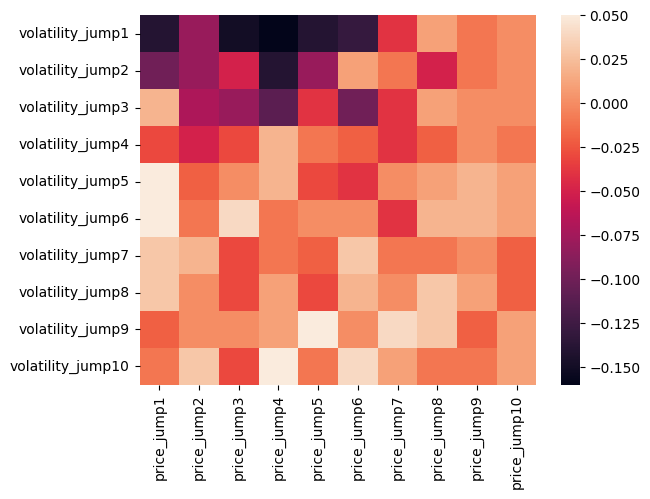

In [102]:
ranking_matrix = [[0] * 10 for _ in range(10)]

# Populate the matrix (for demonstration purposes)
for i in range(10):
    for j in range(10):
            if 'Fisher_test_new' == reshaped_list[i][j][0][0]:
                ranking_matrix[i][j] = reshaped_list[i][j][0][1] - reshaped_list[i][j][1][1]
            elif 'Fisher_test_new' == reshaped_list[i][j][1][0]:
                ranking_matrix[i][j] =  reshaped_list[i][j][1][1] - reshaped_list[i][j][0][1]
            else:
                ranking_matrix[i][j] =  reshaped_list[i][j][2][1] - reshaped_list[i][j][0][1]

column_names = []
row_names = []

for i in range(1, 11):
    column_names.append(f'price_jump{i}')
    row_names.append(f'volatility_jump{i}')
ranking_df = pd.DataFrame(ranking_matrix,columns=column_names, index=row_names)
ranking_df
sns.heatmap(ranking_df, annot = False)
plt.show()

# Normalize Test Statistic Values (x)

In [103]:
def normalized_matrix(matrix_norm):
    m = np.mean(matrix_norm)
    s = np.std(matrix_norm)
    return (matrix_norm - m) / s

dfs_norm = []

for df in dfs:
    # Apply functions to transform each DataFrame
    df_normalized = pd.DataFrame()
    
    # Apply the normalized_matrix function to each column of the DataFrame
    df_normalized = df.iloc[:, :9].apply(normalized_matrix)
    
    dfs_norm.append(df_normalized)

dfs_norm[10]


BNS       CPR      TMIN      TMED       PZ2       PZ4       ASJ  \
0   0.486011  0.211576  0.432352  0.731790 -0.363415 -0.328742 -0.891830   
1   0.862833  1.401753  1.068828  1.682634 -0.307648 -0.313304 -0.952614   
2   0.280298 -0.070790  0.529707  0.450000 -0.448596 -0.285931 -0.954232   
3   1.297131  1.049349  0.841382  1.381021  2.340975  2.376769 -0.825961   
4   1.078958  0.856310  1.004445  0.231071 -0.370331 -0.283494  0.004405   
..       ...       ...       ...       ...       ...       ...       ...   
95 -0.782620 -0.313381 -0.484863 -0.323126 -0.311836 -0.331741 -0.987365   
96 -1.125760 -0.108946 -0.878437 -0.374491 -0.360726 -0.323708  0.187406   
97  0.116440  0.217562 -0.019263 -0.494239 -0.346213 -0.315830 -0.789847   
98 -0.095082 -0.154336  0.277146  0.471038 -0.420328 -0.303929  1.587986   
99 -0.385942  0.224401 -0.454358 -0.131564 -0.446777 -0.290880 -0.887942   

          LM        JO  
0  -0.734171  0.182967  
1  -0.103340  2.106832  
2  -0.344517 -0.645223  
3   0.584318  0.611935  
4  -0.186698  0.204417  
..       ...       ...  
95 -0.721428 -0.863952  
96 -0.822625 -0.053117  
97 -0.657269  1.063305  
98 -0.924708  0.352933  
99 -0.296865 -0.607703  

[100 rows x 9 columns]

# Calculate Empirical CDF of Test Values (x)

In [104]:
def transform_data(data):
    
    # Step 1: Compute ECDFs for each column in normalized_matrix
    ecdfs = {}
    for column in data.columns:
        ecdf = sm.distributions.empirical_distribution.ECDF(data[column])
        ecdfs[column] = ecdf

    # Step 2: Apply ECDFs to update the data
    new_p = data.copy()
    for column in data.columns:
        new_p[column] = ecdfs[column](data[column])

    # Step 3: Set new p-value to 0.99999999 if it equals 1
    new_p[new_p == 1] = 0.99999999

    # Step 4: Approximate -2 log cumulative distribution vector for each column
    W = -2 * np.log(1 - new_p)
    
    return W

dfs_W = []  # Initialize list to store transformed DataFrames

# Apply transformation to each DataFrame in dfs_norm
for df_norm in dfs_norm:
    # Transform the current DataFrame
    df_W = transform_data(df_norm)
    
    # Append the transformed DataFrame to dfs_W
    dfs_W.append(df_W)

# dfs_W now contains a list of transformed DataFrames
dfs_W[0]


NameError: name 'sm' is not defined

In [969]:
def transform_data(element):

    element[element == 1] = 0.999
    # Step 4: Approximate -2 log cumulative distribution vector for each column
    W = -2 * np.log(1 - element)
    
    return W

dfs_W = []  # Initialize list to store transformed DataFrames

# Apply transformation to each DataFrame in dfs_norm
for df in dfs_p:
    # Transform the current DataFrame
    df_W = transform_data(df)
    
    # Append the transformed DataFrame to dfs_W
    dfs_W.append(df_W)

# dfs_W now contains a list of transformed DataFrames
dfs_W[50]


BNS       CPR      TMIN      TMED       PZ2       PZ4        ASJ  \
0    5.752160  3.731664  4.470010  1.651100  0.145735  0.150374   0.561542   
1    2.598028  0.166503  2.290137  1.612963  2.241522  3.770769   8.360205   
2    0.771221  0.021450  0.429833  0.141901  0.462714  5.309459   0.590886   
3    5.751648  4.611909  6.287678  7.623157  1.145251  2.676585   1.378124   
4    1.054665  0.313138  1.643155  2.034858  0.362258  3.015349   9.637319   
..        ...       ...       ...       ...       ...       ...        ...   
995  1.022149  0.075903  0.807538  0.501372 -0.000000 -0.000000   0.914425   
996  7.249098  3.782913  4.711796  1.956100  5.730526  6.016206   8.136384   
997  0.309062  0.110700  0.525066  1.704852  1.968755  0.136127   0.388307   
998  0.207530  0.068137  0.155539  1.814008  1.959309  0.164672  13.532609   
999  0.748215  0.192518  1.570435  0.897458 -0.000000 -0.000000   2.243189   

           LM        JO  
0    0.118052  3.443384  
1    2.304857  1.555193  
2    2.739579  0.213727  
3    2.244020  2.444360  
4    0.536028  0.810204  
..        ...       ...  
995  2.861786  2.253327  
996  1.157457  2.141605  
997  1.559684  0.855562  
998  0.624592  0.346661  
999  2.381241  0.432186  

[1000 rows x 9 columns]

# Calculate Covariance Matrix (x)

In [970]:
# List to store covariance matrices
dfs_cov = []

# Compute covariance matrix for each DataFrame in dfs_W
for df_W in dfs_W:
    covar_matrix = df_W.cov()
    dfs_cov.append(covar_matrix)
dfs_cov[5]

BNS       CPR      TMIN      TMED       PZ2       PZ4         ASJ  \
BNS   2.738578  0.811050  2.581619  1.969637  0.685518  0.372041   -2.126139   
CPR   0.811050  0.404856  0.768677  0.585917  0.166470  0.078270   -0.607825   
TMIN  2.581619  0.768677  2.837510  2.282333  0.634405  0.309053   -2.103212   
TMED  1.969637  0.585917  2.282333  2.781855  0.605051  0.412383   -1.845287   
PZ2   0.685518  0.166470  0.634405  0.605051  3.186338  0.838595   -1.730812   
PZ4   0.372041  0.078270  0.309053  0.412383  0.838595  3.192950   -2.009794   
ASJ  -2.126139 -0.607825 -2.103212 -1.845287 -1.730812 -2.009794  105.302353   
LM    0.682427  0.179069  0.631232  0.583430  0.294790  0.294595   -1.667629   
JO    0.633787  0.188369  0.663591  0.849613  0.475891  0.507185   -1.954950   

            LM        JO  
BNS   0.682427  0.633787  
CPR   0.179069  0.188369  
TMIN  0.631232  0.663591  
TMED  0.583430  0.849613  
PZ2   0.294790  0.475891  
PZ4   0.294595  0.507185  
ASJ  -1.667629 -1.954950  
LM    0.753571  0.232515  
JO    0.232515  3.678512

# Convert to matrix from df (x)

In [971]:
# List to store covariance matrices as numpy arrays
dfs_cov_matrix = []

# Compute covariance matrix for each DataFrame in dfs_W
for df_W in dfs_W:
    covar_matrix = df_W.cov().to_numpy()  # Convert DataFrame to numpy array
    dfs_cov_matrix.append(covar_matrix)
dfs_cov_matrix[3]

array([[ 3.5962786 ,  1.04188499,  3.35039711,  2.32372441,  0.44520104,
         0.4356281 , -1.62038729,  0.64941214,  0.39209436],
       [ 1.04188499,  0.55044192,  1.00010197,  0.74959653,  0.11640604,
         0.10826376, -0.45902314,  0.16973518,  0.14201391],
       [ 3.35039711,  1.00010197,  3.65201763,  2.66734956,  0.47512829,
         0.33809894, -1.87669682,  0.57318322,  0.42069765],
       [ 2.32372441,  0.74959653,  2.66734956,  3.55052463,  0.53035978,
         0.28659636, -1.625322  ,  0.60649589,  0.4349898 ],
       [ 0.44520104,  0.11640604,  0.47512829,  0.53035978,  4.36464233,
         0.47558581,  0.16356989,  0.24559205,  0.23057373],
       [ 0.4356281 ,  0.10826376,  0.33809894,  0.28659636,  0.47558581,
         3.25975994, -0.6985043 ,  0.21687105,  0.09894804],
       [-1.62038729, -0.45902314, -1.87669682, -1.625322  ,  0.16356989,
        -0.6985043 , 65.47329157, -0.62631115, -1.03181285],
       [ 0.64941214,  0.16973518,  0.57318322,  0.60649589,  0

## Fisher and Brown P-values (x)

In [972]:
from scipy.stats import chi2
def CombinePValues(covar_matrix, p_values, extra_info = False):
    m = int(covar_matrix.shape[0])
    df_fisher = 2.0*m
    Expected = 2.0*m
    cov_sum = 0
    for i in range(m):
        for j in range(i+1, m):
            cov_sum += covar_matrix[i, j]
        #print "cov sum", cov_sum
    Var = 4.0*m+2*cov_sum
    c = Var/(2.0*Expected)
    df_brown = 2.0*Expected**2/Var
    if df_brown > df_fisher:
        df_brown = df_fisher
        c = 1.0

    x = 2.0 * sum([-np.log(max(p, 1e-10)) for p in p_values])
    #print "x", x
    p_brown = chi2.cdf(df_brown, 1.0*x/c)
    p_fisher = chi2.cdf(df_fisher, 1.0*x)
    
    if extra_info:
        return p_brown, p_fisher, c, df_brown
    else:
        return p_brown, p_fisher
    
results_brown = []
results_fisher = []

# Iterate over each pair of DataFrame (df_p) and NumPy array (df_cov_matrix)
for df_p, cov_matrix in zip(dfs_p, dfs_cov_matrix):
    # Initialize combined results for each pair of DataFrames
    p_brown_list = []
    p_fisher_list = []
    
    # Iterate over each row in the DataFrame
    for idx, row_p in df_p.iterrows():
        p_values = row_p.tolist()
        
        # Call CombinePValues for the current row
        p_brown, p_fisher = CombinePValues(cov_matrix, p_values, extra_info=False)
        
        # Append the results to the respective lists
        p_brown_list.append(p_brown)
        p_fisher_list.append(p_fisher)
    
    # Append the combined results for the current pair of DataFrame and NumPy array to the overall results list
    results_brown.append(p_brown_list)
    results_fisher.append(p_fisher_list)


# Kost's Method (x)

In [ ]:
#Input: An m x n data matrix with each of m rows representing a variable and each of n columns representing a sample. Should be of type numpy.array
#       A vector of m P-values to combine. May be a list or of type numpy.array.
#Output: A combined P-value using Kost's Method.
#        If extra_info == True: also returns the p-value from Fisher's method, the scale factor c, and the new degrees of freedom from Brown's Method
def KostsMethod(data_matrix, p_values, extra_info = False):
    covar_matrix = CalculateKostCovariance(data_matrix)
    return CombinePValues(covar_matrix, p_values, extra_info = extra_info)
    
#Input correlation between two n x n data vectors.
#Output: Kost's approximation of the covariance between the -log cumulative distributions. This is calculated with a cubic polynomial fit.
def KostPolyFit(cor):
    a1, a2, a3 = 3.263, .710, .027 #Kost cubic coeficients
    return a1*cor+a2*cor**2+a3*cor**3
    
#Input: An m x n data matrix with each of m rows representing a variable and each of n columns representing a sample. Should be of type numpy.array.
#       Note: Method does not deal with missing values within the data.
#Output: An m x m matrix of pairwise covariances between the data vectors calculated using Kost's polynomial fit and numpy's pearson correlation function.
def CalculateKostCovariance(data_matrix):
    m = data_matrix.shape[0]
    covar_matrix = np.zeros((m, m))
    for i in range(m):
        for j in range(i+1, m):
            cor, p_val = pearsonr(data_matrix[i, :], data_matrix[j, :])
            covar = KostPolyFit(cor)
            covar_matrix[i, j] = covar
            covar_matrix[j, i] = covar
    return covar_matrix
    

# Cauchy Combination Test (CCT)

In [1]:
import numpy as np

def cauchy_combination_test(p_values, weights=None):
    K = len(p_values)
    if weights is None:
        weights = np.ones(K) / K  # Default: equal weights

    # Compute the Cauchy transformation
    tan_values = np.tan(np.pi * (0.5 - np.array(p_values)))

    # Compute the test statistic
    T = np.sum(weights * tan_values)

    # Compute the final p-value
    combined_p = 0.5 - (1 / np.pi) * np.arctan(T)
    
    return combined_p

# Example Usage
p_values = [0.01, 0.03, 0.05, 0.10]  # Example p-values
cct_p = cauchy_combination_test(p_values)
print(f"Combined p-value: {cct_p}")

Combined p-value: 0.02453555058728507
